### Nuclei Segmentation of BBC039 Cells
#### PI Sonja Aits, Lund University. NBIS: Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)


<h3><center>Abstract</center></h3>
Here we will run a comparison of OTSU vs. Stardist vs. Cellpose vs. Unet vs. Mask-RCNN nuclei segmentation methods evaluated on the BBC039 cells. The Unet neural network will be trained using FastAi library from Jeremy Howard. The comparison of the different models will be performed using a certain Intersection Over Union (IoU) threshold (to account for all levels of overlap between ground truth and prediction) and computing F1 score evaluation metric.

#### Table of Contents:
* [Loading and Visualizing Images and Mask Annotations](#Loading-and-Visualizing-Images-and-Mask-Annotations)
* [OTSU Thresholding Segmantation Method](#OTSU-Thresholding-Segmentation-Method)
* [Advanced Segmentation with Stardist and Cellpose](#Advanced-Segmentation-with-Stardist-and-Cellpose)
* [Train UNET Neural Network for Nuclei Segmentation](#Train-UNET-Neural-Network-for-Nuclei-Segmentation)
* [Train Mask-RCNN Neural Network for Nuclei Segmentation](#Train-Mask-RCNN-Neural-Network-for-Nuclei-Segmentation)

#### Loading and Visualizing Images and Mask Annotations <a class="anchor" id="Loading-and-Visualizing-Images-and-Mask-Annotations"></a>

The BBC039 image set is part of a high-throughput chemical screen on U2OS cells, with examples of 200 bioactive compounds. This data set only includes the DNA channel of a single field of view per compound. The main use of this data set is the study of segmentation algorithms that can separate individual nucleus instances in an accurate way, regardless of their shape and cell density. 

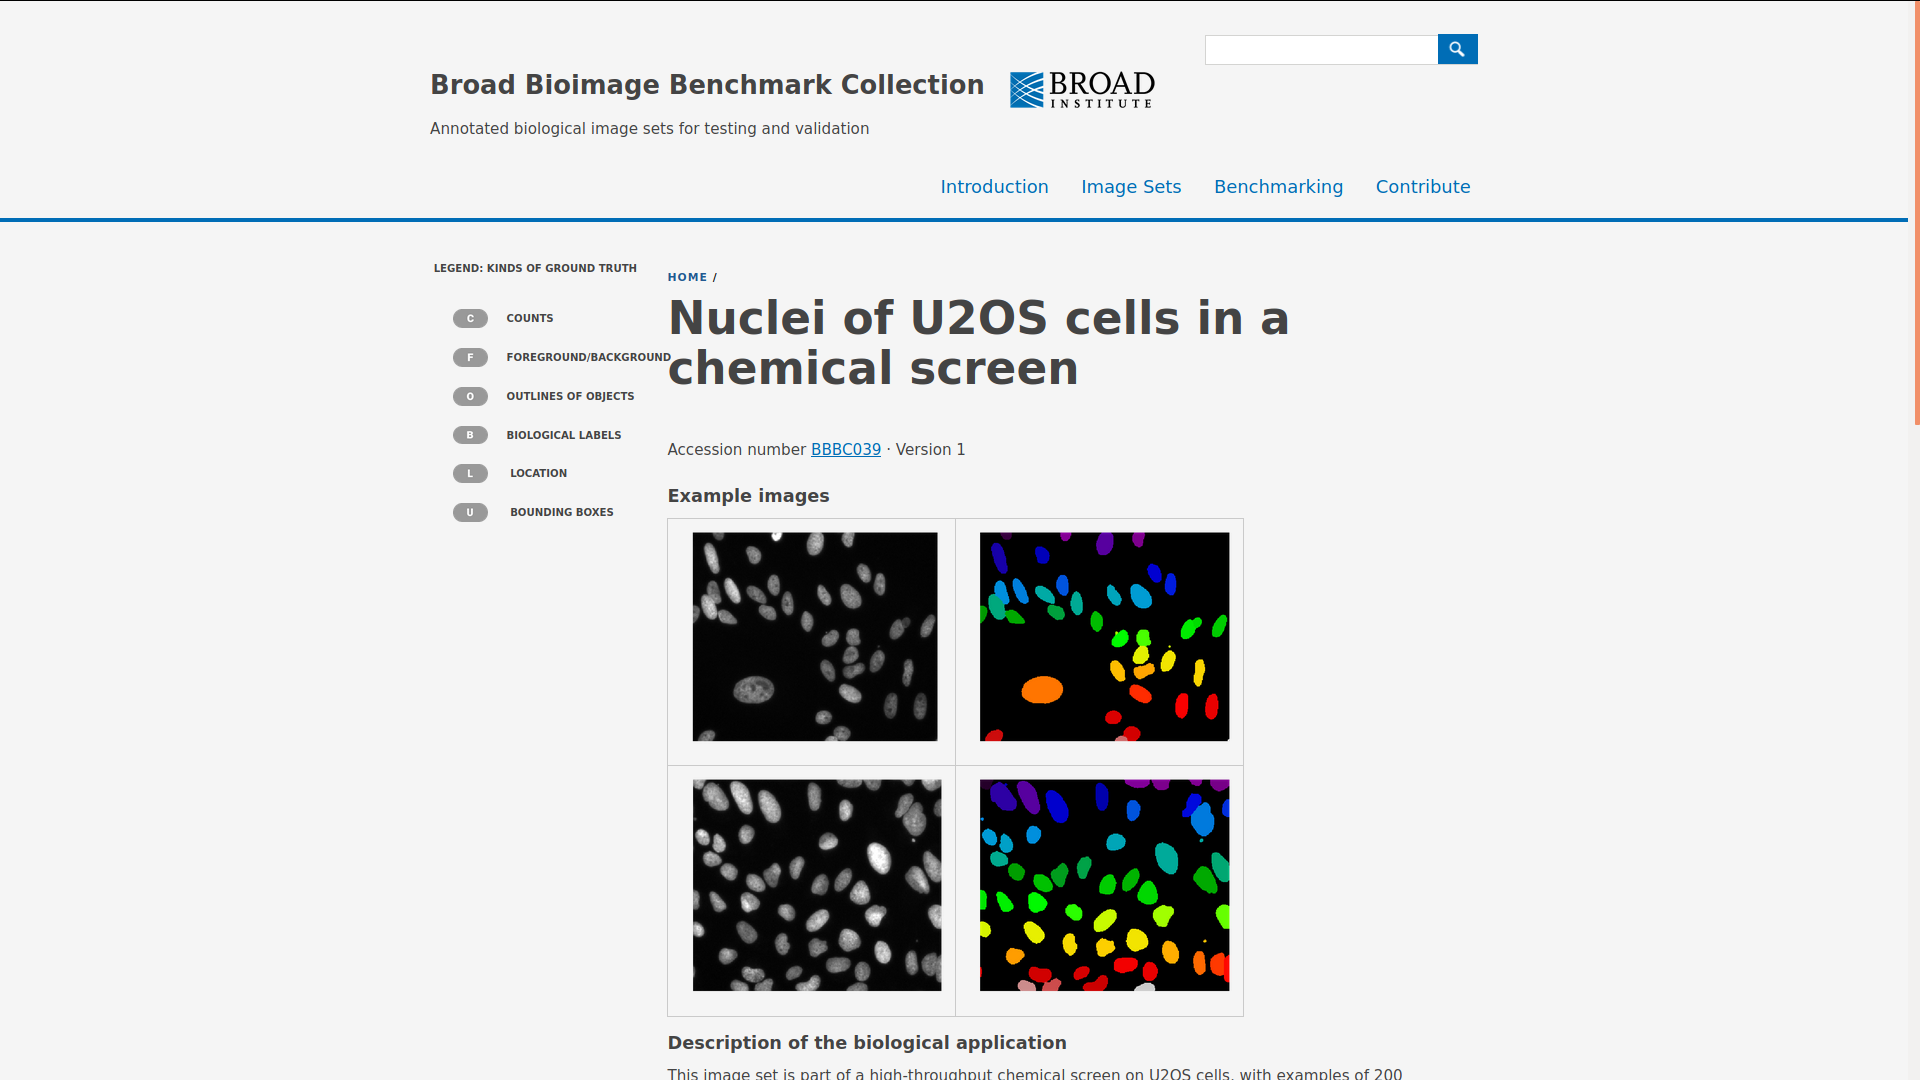

In [1]:
from IPython.display import Image
Image('BBBC039.png', width = 2000)

This data set has a total of 200 images of nuclei captured with fluorescence microscopy using the Hoechst stain. The images are stored as TIFF files with 520x696 pixels at 16 bits. Ground truth annotations are stored as PNG files encoding masks of independent nuclei: **if two nuclei touch, they are labeled with a different color**. These annotations need to be decoded into labelled matrices to be used as ground truth. The original annotation masks / labels are RGB images, but we are going to convert them to **grayscale** by keeping only the first channel.

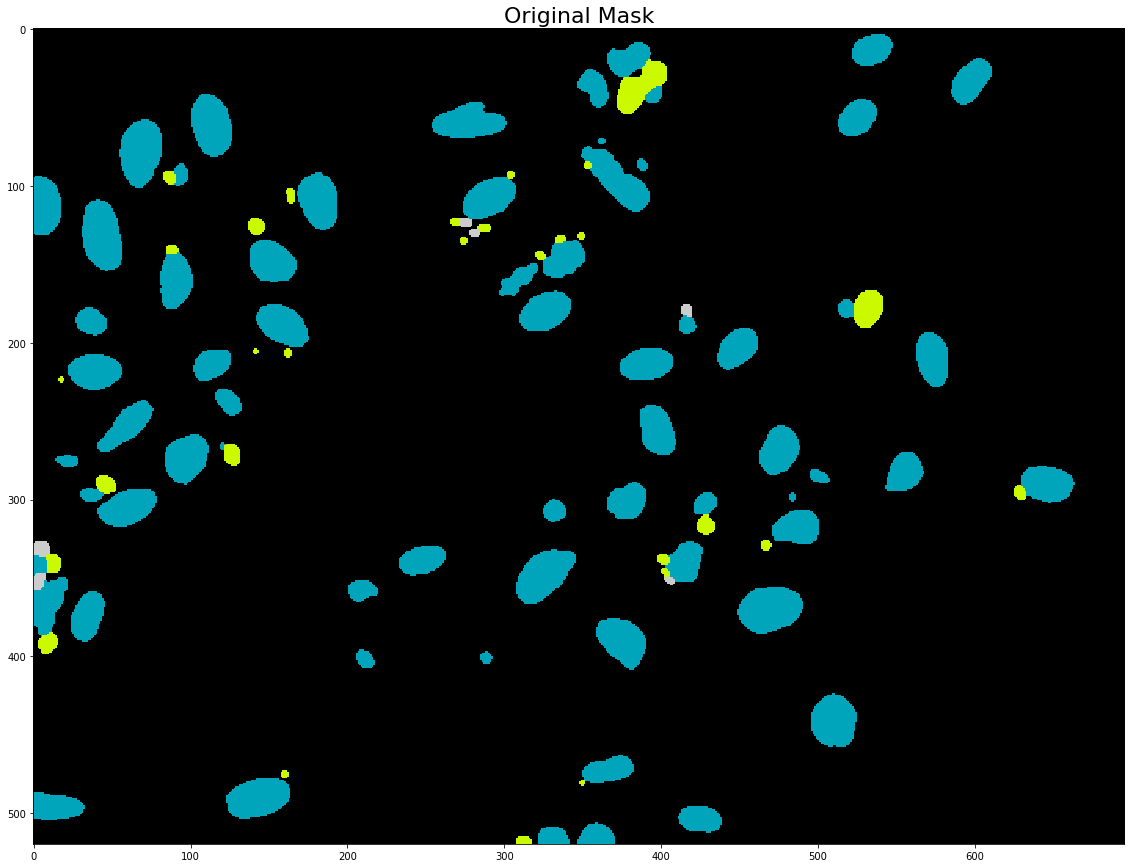

In [49]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology

import warnings
warnings.filterwarnings('ignore')

masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks_rgb/masks/"
#gt = skimage.io.imread(masks_path + "IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png")
gt = skimage.io.imread(masks_path + "IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06.png")

# Keep first channel only
gt = gt[:,:,0]

plt.figure(figsize = (20,15))
plt.imshow(gt, cmap = 'nipy_spectral')
plt.title('Original Mask', fontsize = 22)
plt.show()

In [50]:
gt.shape

(520, 696)

In [51]:
np.max(gt)

3

In the image above we can visually distinguish 4 different shades of gray. This is because there are **4 classes present in the mask images: background (0), nuclei (1), touching nuclei (2), and in-between touching nuclei (3)**. In other words, each pixel in the mask image belongs to one of the four classes. This becomes very clear when we plot the histograms of the class codes for the maks image.

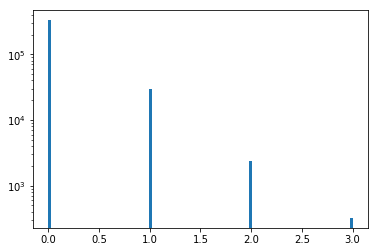

In [52]:
import matplotlib.pyplot as plt
plt.hist(gt.flatten(), bins = 100, log = True)
plt.show()

However, for later usage and comparison of the models, we need to convert the original 4 class masks to the so-called [connected independent components (cic)](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.label) masks by coding similar pixels with independent labels:

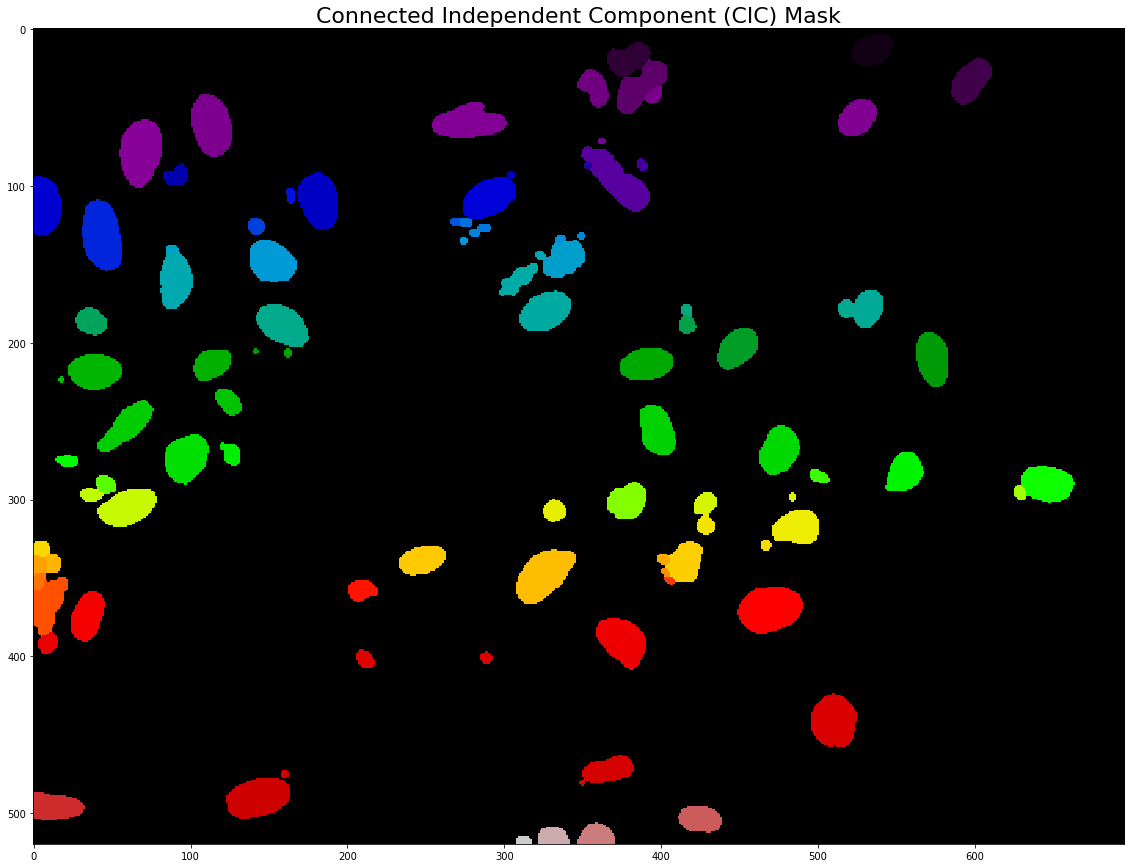

In [53]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology

import warnings
warnings.filterwarnings('ignore')

masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks_rgb/masks/"
#gt = skimage.io.imread(masks_path + "IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png")
gt = skimage.io.imread(masks_path + "IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06.png")
# Keep first channel only
gt = gt[:,:,0]

# Label independent connected components
gt_cic = skimage.morphology.label(gt)

plt.figure(figsize = (20,15))
plt.imshow(gt_cic, cmap = 'nipy_spectral')
plt.title('Connected Independent Component (CIC) Mask', fontsize = 22)
plt.show()

We can also check what pixel intensity distribution we get if we apply the Connecting Independent Components (CIC) algorithm to the original masks.

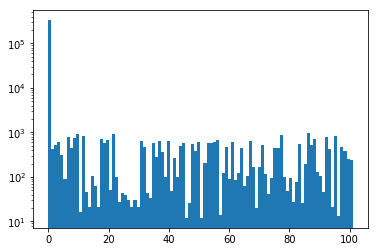

In [54]:
import matplotlib.pyplot as plt
plt.hist(gt_cic.flatten(), bins = 100, log = True)
plt.show()

In [55]:
np.unique(gt_cic.flatten())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

In [56]:
gt_cic.shape

(520, 696)

In [57]:
from skimage.color import label2rgb
label2rgb(skimage.morphology.label(gt)).shape

(520, 696, 3)

In [58]:
#masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks_rgb/masks/"
#gt = skimage.io.imread(masks_path + "IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png")
#mask = skimage.io.imread(path).astype(np.bool)

In [59]:
#gt.shape[-1]

In [60]:
#import keras
#keras.utils.to_categorical(gt_cic).shape

Looks like there are 111 unique labels for the pixels in the mask after we converted the original 4 classes mask into a continuous mask by connecting indepepndent components meaning unifying similar pixels under the same label. Once we have preformed the CIC conversion of the mask, there does not seem unfortunately be a way to reconstruct the original mask with the 4 classes, even though using the **label2rgb** scikitimage function we do get a multinomial distribution with 4 classes present but the true frequencies of the classes are gone.

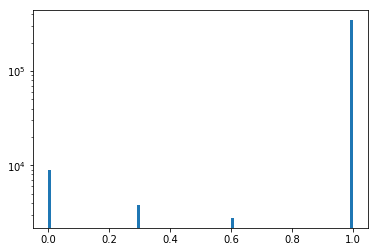

In [61]:
import matplotlib.pyplot as plt
plt.hist(skimage.color.label2rgb(gt_cic)[:,:,0].flatten(), bins = 100, log = True)
plt.show()

Let us now check how a typical image looks like and how it compares with the masks annotations provided by te Broad Institute. We will normalize the pixel intensities of the image to a range [0, 1] for a better contrast. Below we will also plot the pixel intensity distribution in order to see whether it is a bit bimodal implying that we have a background (0 pixel intensity) or foreground (non-zero pixel intensity).

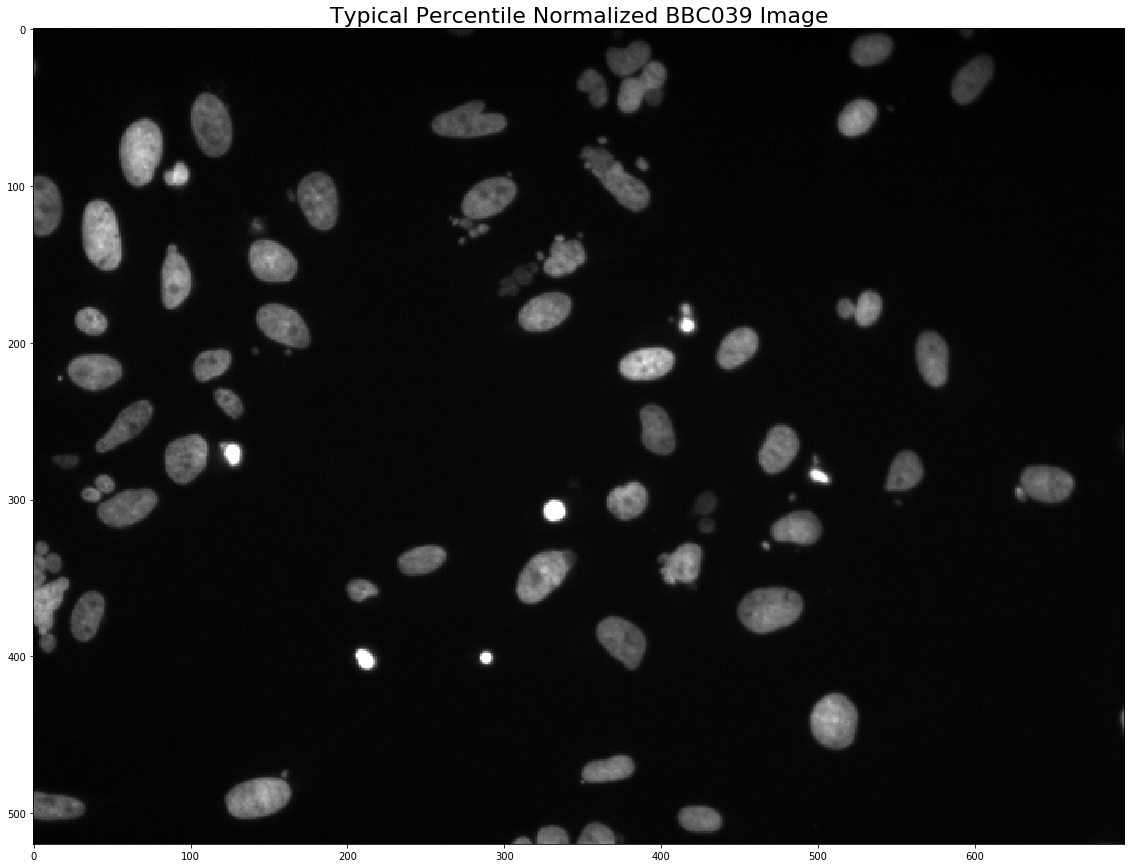

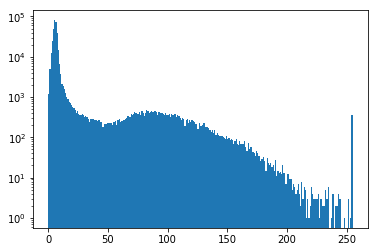

In [62]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

images_path = "/home/nikolay/WABI/S_Aits/segmentation/images/images/"
#img = skimage.io.imread(images_path + "IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.tif")
img = skimage.io.imread(images_path + "IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06.tif")

# normalize to [0,1]
percentile = 99.9
high = np.percentile(img, percentile)
low = np.percentile(img, 100 - percentile)

img = np.minimum(high, img)
img = np.maximum(low, img)

img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
img = skimage.img_as_ubyte(img) 

plt.figure(figsize = (20, 15))
plt.imshow(img, cmap = 'gray')
plt.title('Typical Percentile Normalized BBC039 Image', fontsize = 22)
plt.show()
plt.hist(img.flatten(), bins = 255, log = True)
plt.show()

Here we also plotted the histogram of pixel intensities on the image. We can clearly see that most of the pixels have intensity close to 0, which means they belong to the background. The histogram looks somewhat bimodal, we can clearly see another small peak at around pixel intensity of 100, those pixels probably belong to the nuclei (second largest class). Let us now put the image and corresponding ground truth mask next to each other in order to see that the mask perfectly captures the cell nuclei on the image.

In [63]:
print(img.dtype, img.shape)

uint8 (520, 696)


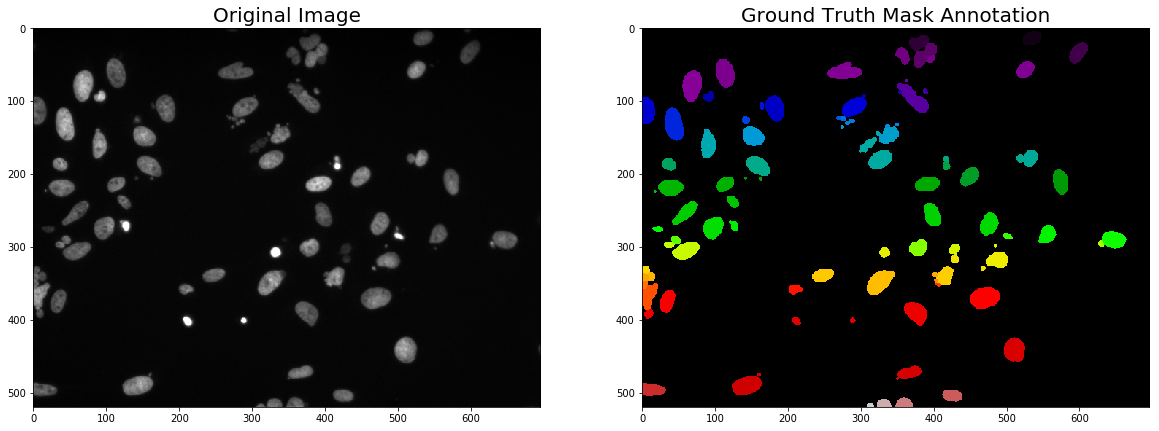

In [64]:
plt.figure(figsize = (20,15))

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image', fontsize = 20)

plt.subplot(122)
plt.imshow(gt_cic, cmap = 'nipy_spectral')
plt.title('Ground Truth Mask Annotation', fontsize = 20)
plt.show()

Looks like the mask annotations overlap the cells on the image really well. Now we will use OTSU thresholding for creating our own masks. OTSU will essentially find a threshold that separates the background and foreground on each image. We will also evaluate the overlap between the provided masks and the ones created by OTSU segmentation thresholding method.

#### OTSU Thresholding Segmentation Method <a class="anchor" id="OTSU-Thresholding-Segmentation-Method"></a>

Now we will create our own mask annotations using simple Multi-OTSU thresholding method. This method determins a pixel intensity threshold above which all the pixels are considered as signal belonging to classes nuclei / touching nuclei / small touching nuclei, while pixel with intensities below this threshold are assigned to background. To force OTSU to find thresholds for 2 classes, we provide the classes = 2 argument.

In [65]:
import skimage

# Applying multi-Otsu threshold for the default value, generating 2 classes.
thresholds = skimage.filters.threshold_multiotsu(img, classes = 2)

# Using the threshold values, we generate an OTSU mask with 2 regions.
regions = np.digitize(img, bins = thresholds)
regions

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [66]:
np.max(regions)

1

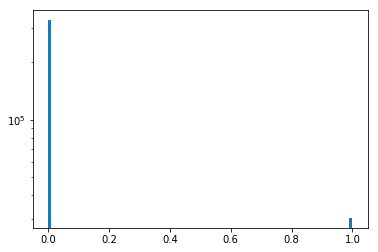

In [67]:
plt.hist(regions.flatten(), bins = 100, log = True)
plt.show()

Good, the Multi-OTSU seems to have split the range of pixel intensities into 2 classes. The multionomial distribution of the mask labels seems to resemble the one from the original ground truth mask without CIC convertion. Let us visualize how exactly the Multi-OTSU split the pixel intensities into 2 clusters.

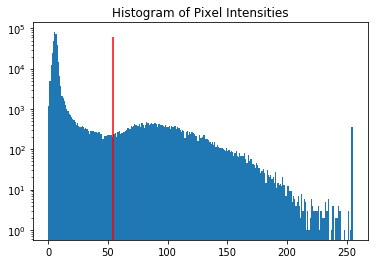

In [68]:
# Plotting the histogram and the threshold obtained from Multi-Otsu
plt.hist(img.ravel(), bins = 255, log = True)
plt.title('Histogram of Pixel Intensities')
for thresh in thresholds:
    plt.vlines(thresh, 0, 60000, color = 'r')
plt.show()

We can see that the thresholds found by Multi-OTSU thresholding method split somewhat strangly the histogram of the pixel intensities. For example, the second threshold falls in the middle of the second peak on the pizel intensity histigram, while it would make more sense to assign all pixels with the intensities around the second peak to the second largest cluster. Let us now display the ground truth mask (from Broad Institute) and the one created by the OTSU thresholding method next to each other.

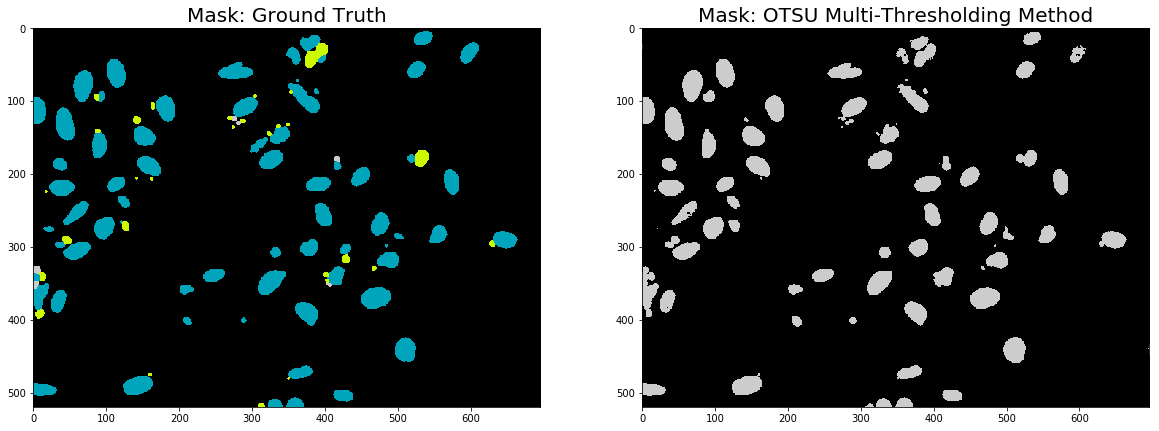

In [69]:
plt.figure(figsize = (20,15))

plt.subplot(121)
plt.imshow(gt, cmap = 'nipy_spectral')
plt.title('Mask: Ground Truth', fontsize = 20)

plt.subplot(122)
plt.imshow(regions, cmap = 'nipy_spectral')
plt.title('Mask: OTSU Multi-Thresholding Method', fontsize = 20)
plt.show()

We can see here that Multi-OTSU mistakenly assigned the yellow color to the blue nuclei, which we could also conclude from the multinomial distribution above, where the third class (yellow nuclei) seemed to be equally frequent as the second class (blue nuclei). So multi-OTSU thought that many of the regular nuclei were touching nuclei which is not the case. Now let us display the original image and the images with the Multi-OTSU mask superimposed next to each other.

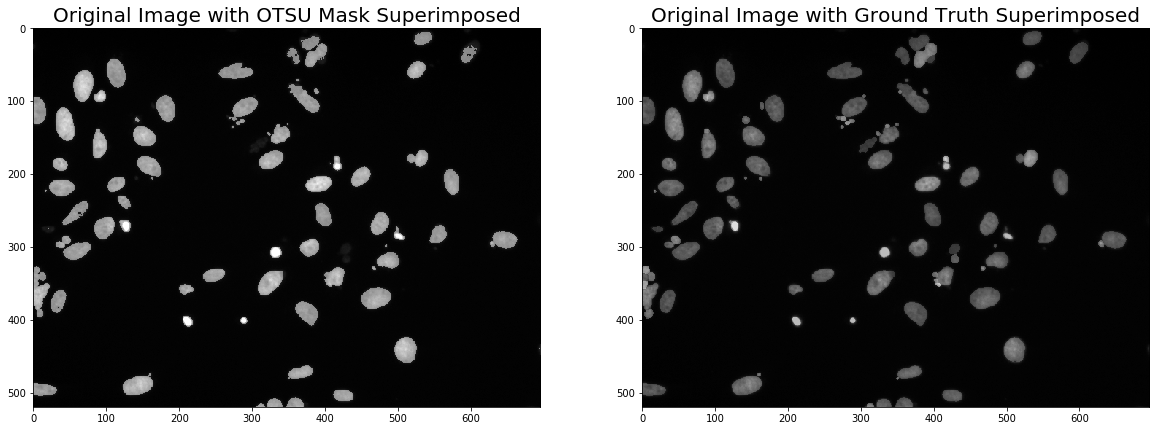

In [70]:
plt.figure(figsize = (20,15))

plt.subplot(121)
plt.imshow(img, cmap = 'gray')    
plt.imshow(regions, alpha = 0.4, cmap = 'gray')
plt.title('Original Image with OTSU Mask Superimposed', fontsize = 20)

plt.subplot(122)
plt.imshow(img, cmap = 'gray')    
plt.imshow(gt, alpha = 0.4, cmap = 'gray')
plt.title('Original Image with Ground Truth Superimposed', fontsize = 20)

plt.show()

Now let us compute accuracy of classification of the pixels between the 4 classes on the images. In this way we will find a percentage of pixels that were classified correctly to belong to one of the 4 classes compared to the ground truth masks from the Broad Institute.

In [71]:
from sklearn.metrics import accuracy_score
accuracy_score(gt.flatten(), regions.flatten())

0.9848005083996463

This is quite a high accuracy meaning almost ~87% of pixels were classified correctly, i.e. belonging either to the background or nuclei or touching nuclei or in-between touching nuclei. However, since we have an imbalanced data set, i.e. the background class is very dominating, the accuracy is not good evaluation metric. Below for evaluation we will use the F1 score with macro-averaging, i.e. producing 4 ROC-curves for each class and averaging them. Because the minority class typically has a very poor ROC-curve, this class will dramattically decrease the F1 score, which is equivalent to the area under the ROC curve.

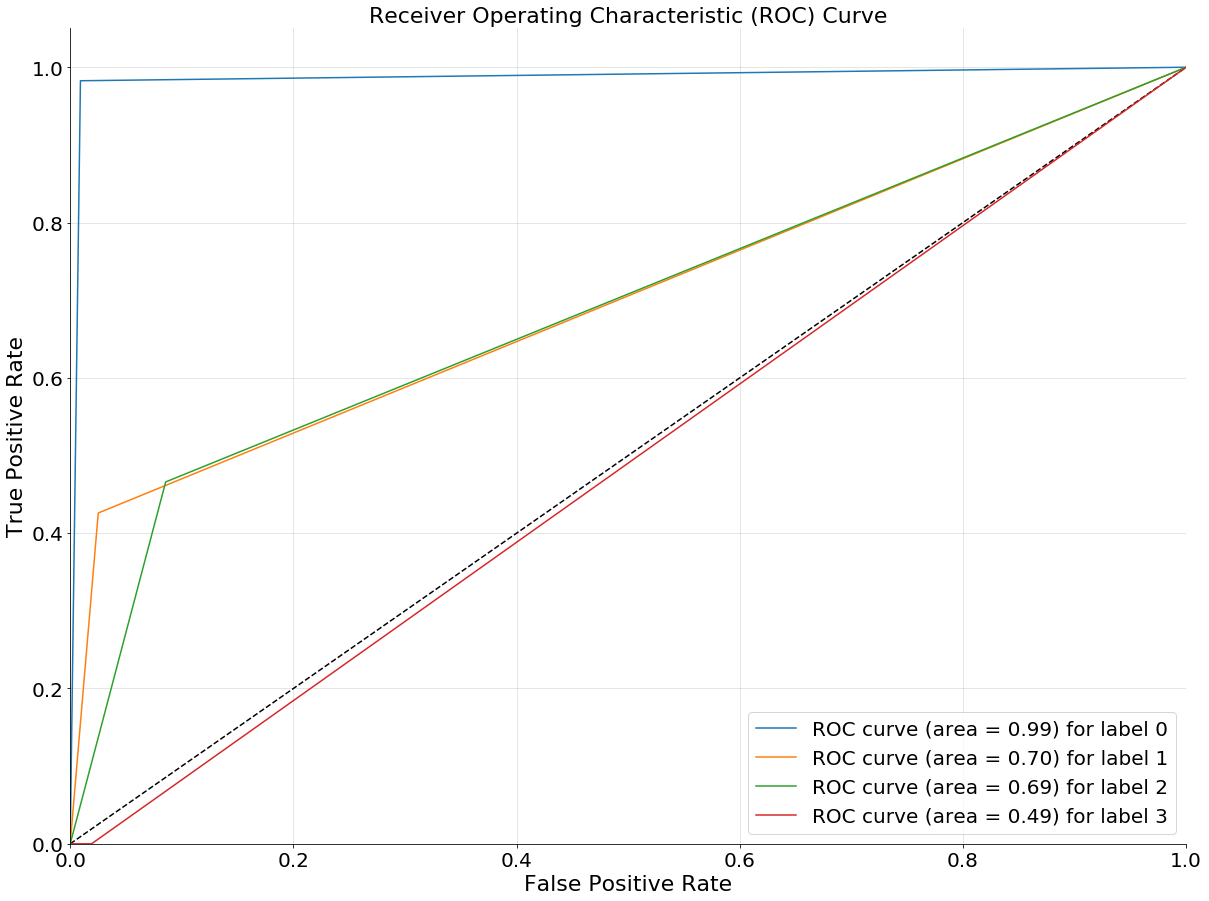

In [23]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(prediction, ground_truth, n_classes, figsize = (20, 15)):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    ground_truth_dummies = pd.get_dummies(ground_truth, drop_first = False).values
    prediction_dummies = pd.get_dummies(prediction, drop_first = False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ground_truth_dummies[:, i], prediction_dummies[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize = 22)
    ax.set_ylabel('True Positive Rate', fontsize = 22)
    ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize = 22)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(regions.flatten(), gt.flatten(), 4)

We can see that the ROC-curves are very different for the 4 classes. The ROC-cuve for background recognition looks perfect, while ROC-curves for the nuclei and touching neuclei are much worse. Recognition of the fouth class (in-between touching nuclei) basically failed, the ROC-curve for the fourth class is comparable with the one from a random classifier. Let us now compute the macro-averaged (computed for each class separately and averaged across classes) F1-score as an alternative to the macro-averaged AUC ROC-curve.

In [72]:
from sklearn.metrics import f1_score
f1_score(gt.flatten(), regions.flatten(), average = 'macro')

0.4784472645113999

We can see that the macro-averaged F1 score gives us a more reasonable evaluation of how successful was the Multi-OTSU segmentation. Please note that so far we have used the original ground truth mask and the predicted Multi-OTSU mask **without CIC conversion**. However, even though this is a more intuitively clear way to evaluate a model, for later comparison with Stardist and Cellpose we will need to evaluate Multi-OTSU segmentation using the CIC transformed masks. This is because to my knowledge Stardist and Cellpose can only deliver predictions as CIC masks, so using the masks with 4 classes of pixels from Multi-OTSU we can not compare them with the masks from Stardist and Cellpose. Therefore, let us now compute **CIC converted Multi-OTSU segmentation masks**.

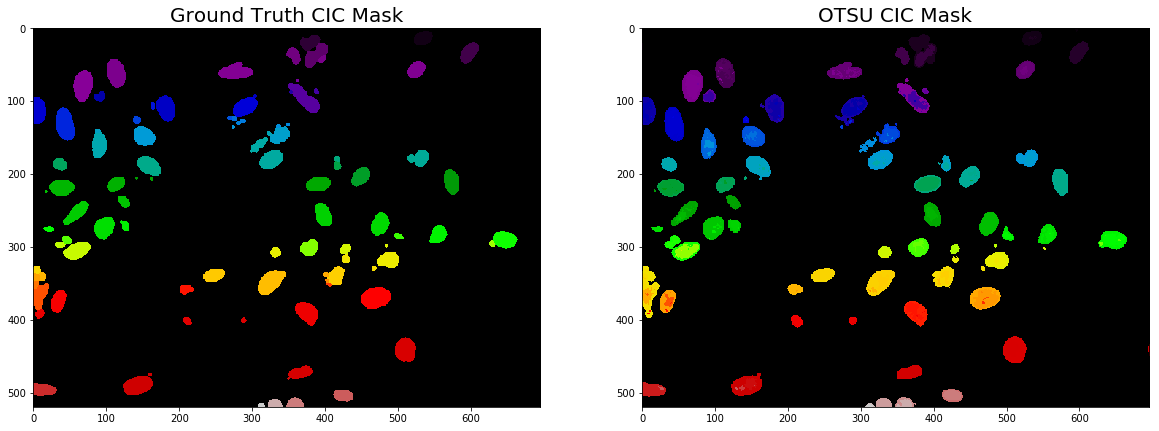

In [73]:
#thresh_val = skimage.filters.threshold_otsu(img)
#mask_otsu = skimage.morphology.label(np.digitize(img, bins = [thresh_val])) # continuous scale mask

thresholds = skimage.filters.threshold_multiotsu(img, classes = 4)
mask_otsu = skimage.morphology.label(np.digitize(img, bins = thresholds))

plt.figure(figsize = (20,15))

plt.subplot(121)
plt.imshow(gt_cic, cmap = 'nipy_spectral')
plt.title('Ground Truth CIC Mask', fontsize = 20)

plt.subplot(122)
plt.imshow(mask_otsu, cmap = 'nipy_spectral')
plt.title('OTSU CIC Mask', fontsize = 20)
plt.show()

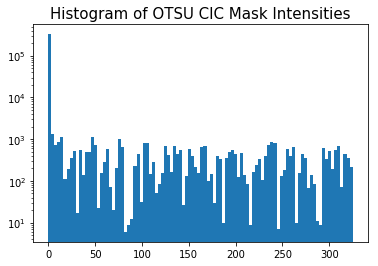

In [74]:
plt.hist(mask_otsu.flatten(), bins = 100, log = True)
plt.title('Histogram of OTSU CIC Mask Intensities', fontsize = 15)
plt.show()

We conclude that the ground truth CIC mask and the OTSU CIC mask looks quite similar. To eveluate the succes of the nuclei segmentation, we will use a function from the Strdist library that computes multiple evaluation metrics, including F1 score, using different Intersection Over Union (IoU) thresholds. Here we demand ground truth CIC mask to overlap with the OTSU CIC masks at different $\tau$ levels varying from 10% to 100% (perfect) overlap and compute the F1 score from False Positive and False Negative rates.

In [75]:
from stardist.matching import matching_dataset
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
stats_otsu = [matching_dataset(mask_otsu, gt_cic, thresh = t, show_progress = False) for t in taus]

In [76]:
f1_otsu = [stats_otsu[i]._asdict()['f1'] for i in range(len(taus))]
f1_otsu

[0.6219278368485271,
 0.6149555516820638,
 0.6055429667073383,
 0.5961303817326129,
 0.5616175701586195,
 0.44692347917029807,
 0.33885305909011676,
 0.23252571030155134,
 0.10388704898030329,
 0.03276974028237755]

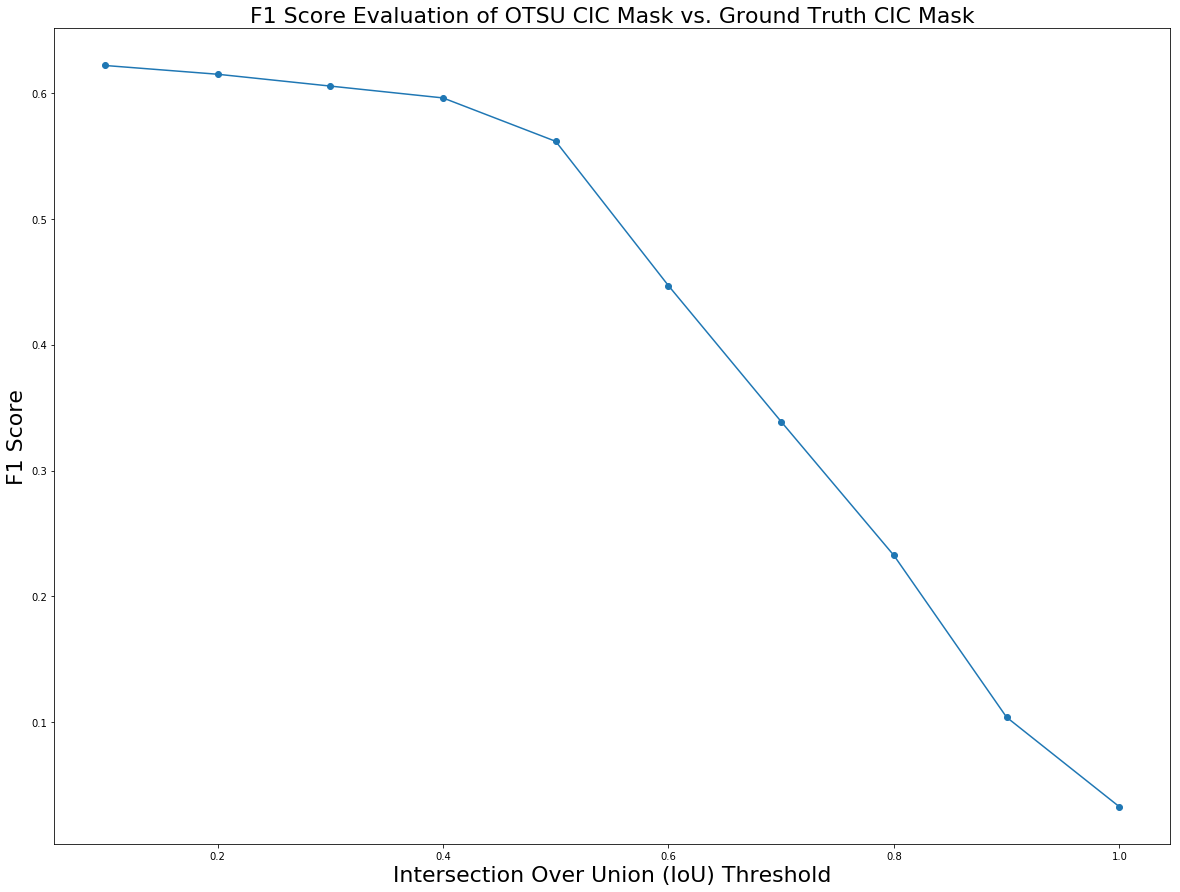

In [77]:
plt.figure(figsize = (20,15))
plt.plot(taus, f1_otsu, '-o')
plt.title('F1 Score Evaluation of OTSU CIC Mask vs. Ground Truth CIC Mask', fontsize = 22)
plt.xlabel('Intersection Over Union (IoU) Threshold', fontsize = 22)
plt.ylabel('F1 Score', fontsize = 22)
plt.show()

Let us now compare the simple OTSU thresholding method with advanced Machine Learning (ML) based methods such as **Stardist** and **Cellpose** that use a combination of Deep Learning and diffusion based cell map.

#### Advanced Segmentation with Stardist and Cellpose <a class="anchor" id="Advanced-Segmentation-with-Stardist-and-Cellpose"></a>

We will start with Stardist image segmentation framework. It is quite easy to run it, let us demonstrate it. First we load the pre-trained Stardist model:

In [78]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

model_stardist = StarDist2D.from_pretrained('2D_paper_dsb2018')

Found model '2D_paper_dsb2018' for 'StarDist2D'.
Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.


In [79]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


Now we normalize the image and run model predictions:

In [80]:
image_norm = normalize(img, 1, 99.8)
mask_stardist, details = model_stardist.predict_instances(image_norm)

In [81]:
details.keys()

dict_keys(['coord', 'points', 'prob'])

Next, let us visualize the mask that the Stardist model has predicted on the BBC039 cell images.

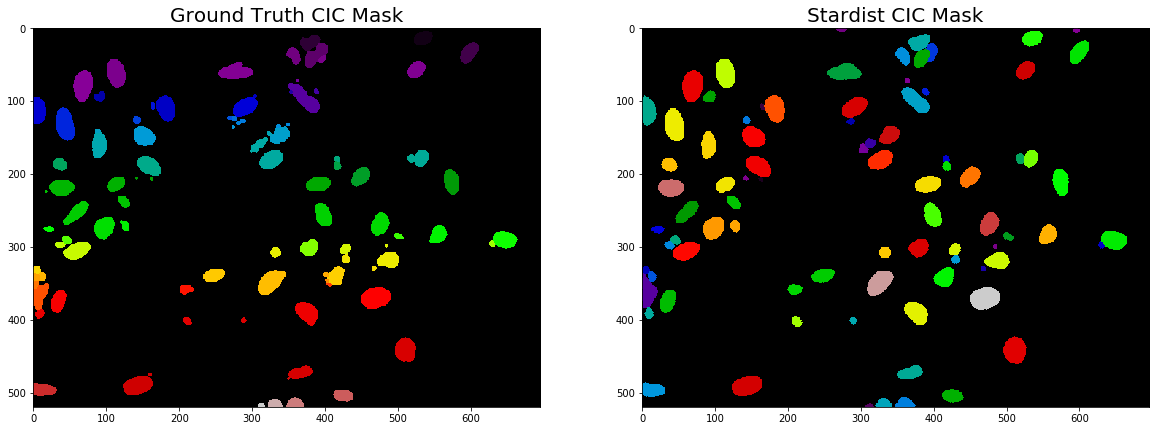

In [82]:
plt.figure(figsize = (20,15))

plt.subplot(121)
plt.imshow(gt_cic, cmap = 'nipy_spectral')
plt.title('Ground Truth CIC Mask', fontsize = 20)

plt.subplot(122)
plt.imshow(mask_stardist, cmap = 'nipy_spectral')
plt.title('Stardist CIC Mask', fontsize = 20)
plt.show()

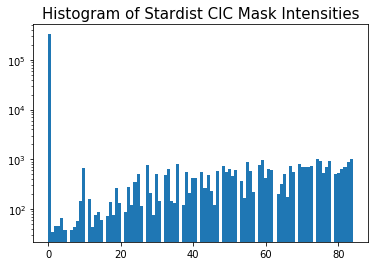

In [83]:
plt.hist(mask_stardist.flatten(), bins = 100, log = True)
plt.title('Histogram of Stardist CIC Mask Intensities', fontsize = 15)
plt.show()

Finally, we are going to evaluate Stardist mask predictions using different IuO thresholds, and compare the OTSU and Stardist CIC masks match against the ground truth CIC mask.

In [84]:
from stardist.matching import matching_dataset
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
stats_stardist = [matching_dataset(mask_stardist, gt_cic, thresh = t, show_progress = False) for t in taus]

In [85]:
f1_stardist = [stats_stardist[i]._asdict()['f1'] for i in range(len(taus))]
f1_stardist

[0.9224067519738633,
 0.9175061257827389,
 0.9098829294854343,
 0.9006261911244214,
 0.883746256466104,
 0.8478083310645249,
 0.8009801252382249,
 0.7171249659678737,
 0.48407296487884566,
 0.05499591614484073]

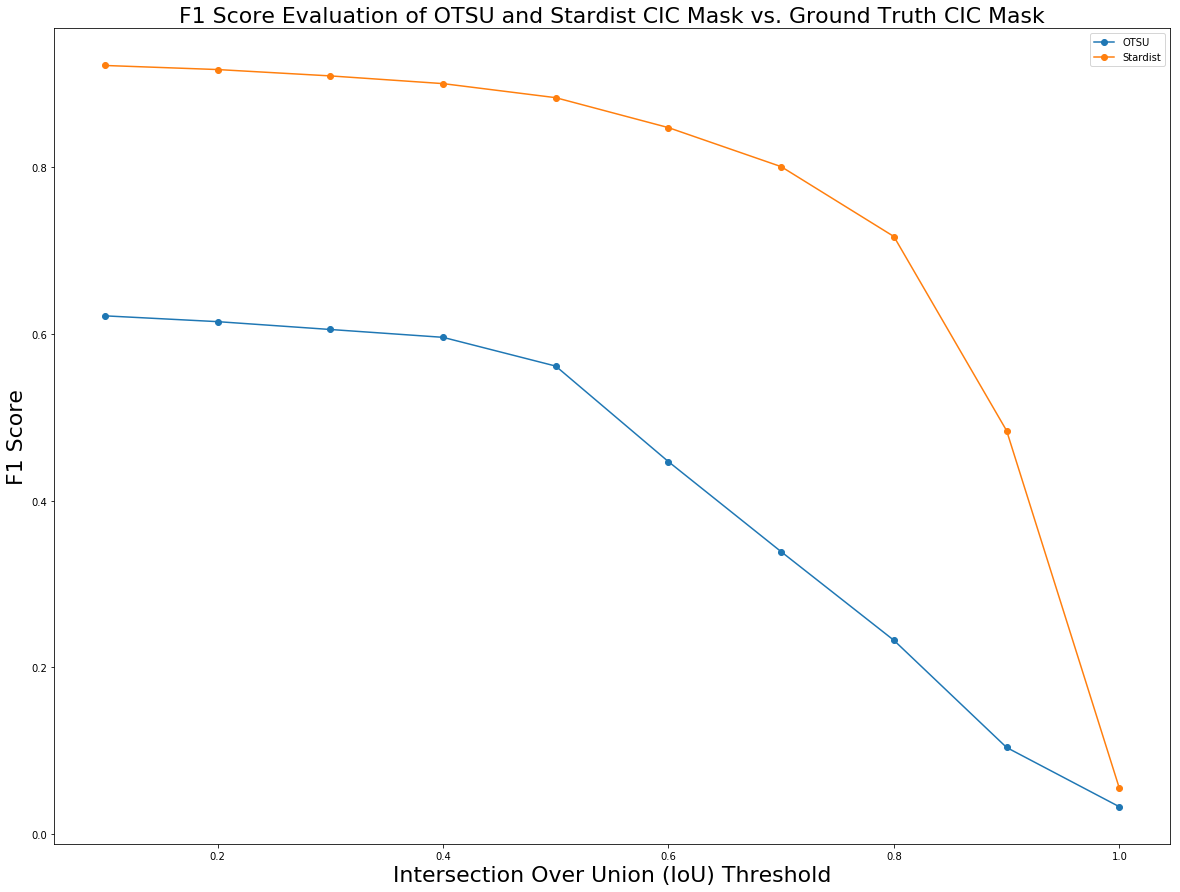

In [86]:
plt.figure(figsize = (20,15))
plt.plot(taus, f1_otsu, '-o')
plt.plot(taus, f1_stardist, '-o')
plt.title('F1 Score Evaluation of OTSU and Stardist CIC Mask vs. Ground Truth CIC Mask', fontsize = 22)
plt.xlabel('Intersection Over Union (IoU) Threshold', fontsize = 22)
plt.ylabel('F1 Score', fontsize = 22)
plt.legend(['OTSU', 'Stardist'])
plt.show()

Looks like an excellent prediction, and it is higher than the one from the OTSU thresholding method! Now we will proceed with the Cellpose model.

In [87]:
import mxnet
from cellpose import models
model = models.Cellpose(device = mxnet.cpu(), model_type = "nuclei")

cellpose_residual_on_style_on_concatenation_off


In [88]:
mask_cellpose_array, _, _, _ = model.eval([img[::1, ::1]], channels = [[0, ]], diameter = 20)
mask_cellpose = mask_cellpose_array[0]

processing 1 image(s)
time spent: running network 15.22s; flow+mask computation 0.46
estimated masks for 1 image(s) in 15.70 sec
>>>> TOTAL TIME 15.70 sec


Next, let us visualize the mask that the Cellpose model has predicted on the BBC039 cell images.

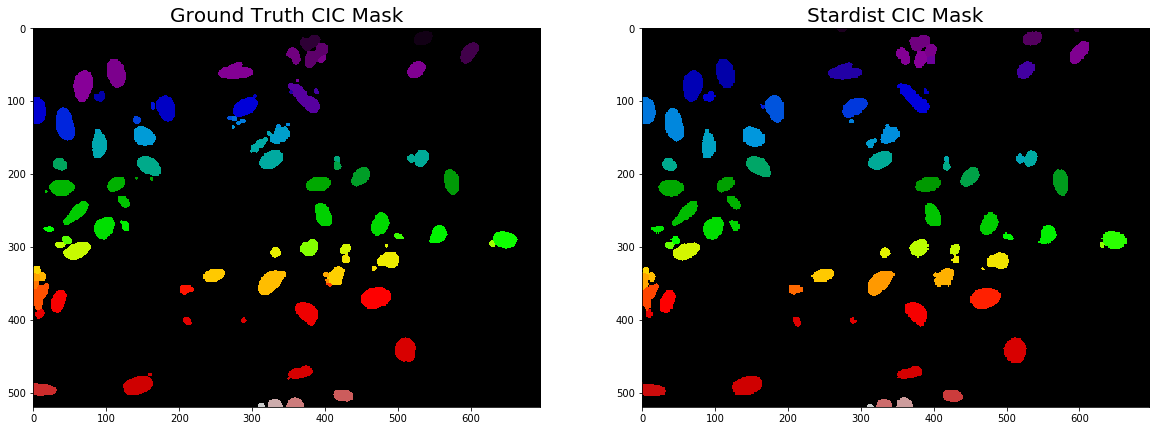

In [89]:
plt.figure(figsize = (20,15))

plt.subplot(121)
plt.imshow(gt_cic, cmap = 'nipy_spectral')
plt.title('Ground Truth CIC Mask', fontsize = 20)

plt.subplot(122)
plt.imshow(mask_cellpose, cmap = 'nipy_spectral')
plt.title('Stardist CIC Mask', fontsize = 20)
plt.show()

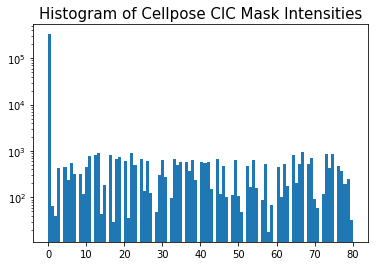

In [90]:
plt.hist(mask_cellpose.flatten(), bins = 100, log = True)
plt.title('Histogram of Cellpose CIC Mask Intensities', fontsize = 15)
plt.show()

And again, we are going to evaluate Cellpose mask predictions using different IuO thresholds, and compare the OTSU vs. Stardist vs. Cellpose CIC masks match against the ground truth CIC mask.

In [91]:
from stardist.matching import matching_dataset
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
stats_cellpose = [matching_dataset(mask_cellpose, gt_cic, thresh = t, show_progress = False) for t in taus]

In [92]:
f1_cellpose = [stats_cellpose[i]._asdict()['f1'] for i in range(len(taus))]
f1_cellpose

[0.9326570865032403,
 0.9320935474781629,
 0.925331079177233,
 0.9208227669766131,
 0.9061707523245984,
 0.8875739644970414,
 0.8492533107917724,
 0.775993237531699,
 0.5956607495069034,
 0.15046491969568893]

In [93]:
stats_cellpose[-2]._asdict()['f1']

0.5956607495069034

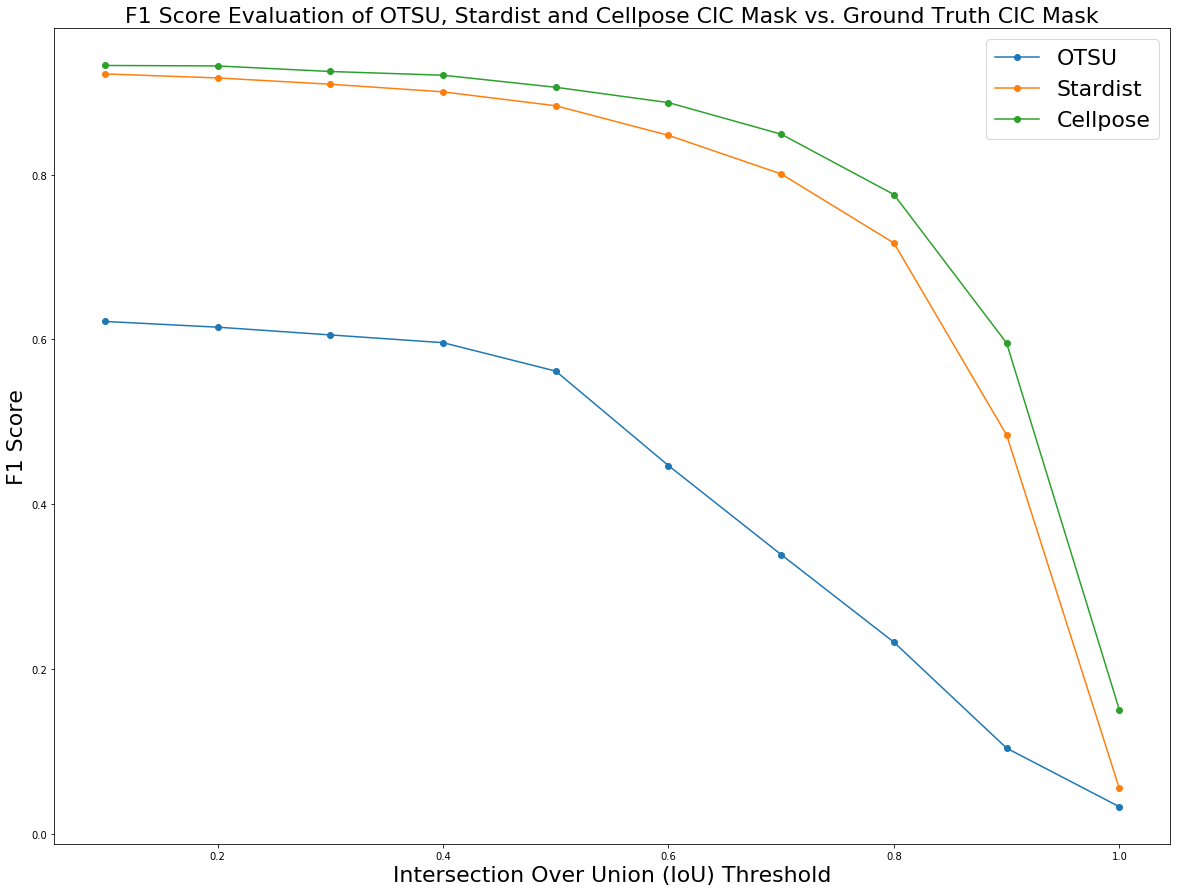

In [95]:
plt.figure(figsize = (20,15))
plt.plot(taus, f1_otsu, '-o')
plt.plot(taus, f1_stardist, '-o')
plt.plot(taus, f1_cellpose, '-o')
plt.title('F1 Score Evaluation of OTSU, Stardist and Cellpose CIC Mask vs. Ground Truth CIC Mask', fontsize = 22)
plt.xlabel('Intersection Over Union (IoU) Threshold', fontsize = 22)
plt.ylabel('F1 Score', fontsize = 22)
plt.legend(['OTSU', 'Stardist', 'Cellpose'], fontsize = 22)
plt.show()

Looks excellent, the IoU score from the Cellpose segmentation method is higher than for both OTSU and Stardist! Let us visualize the ground truth, OTSU, Stardist and Cellpose CIC masks.

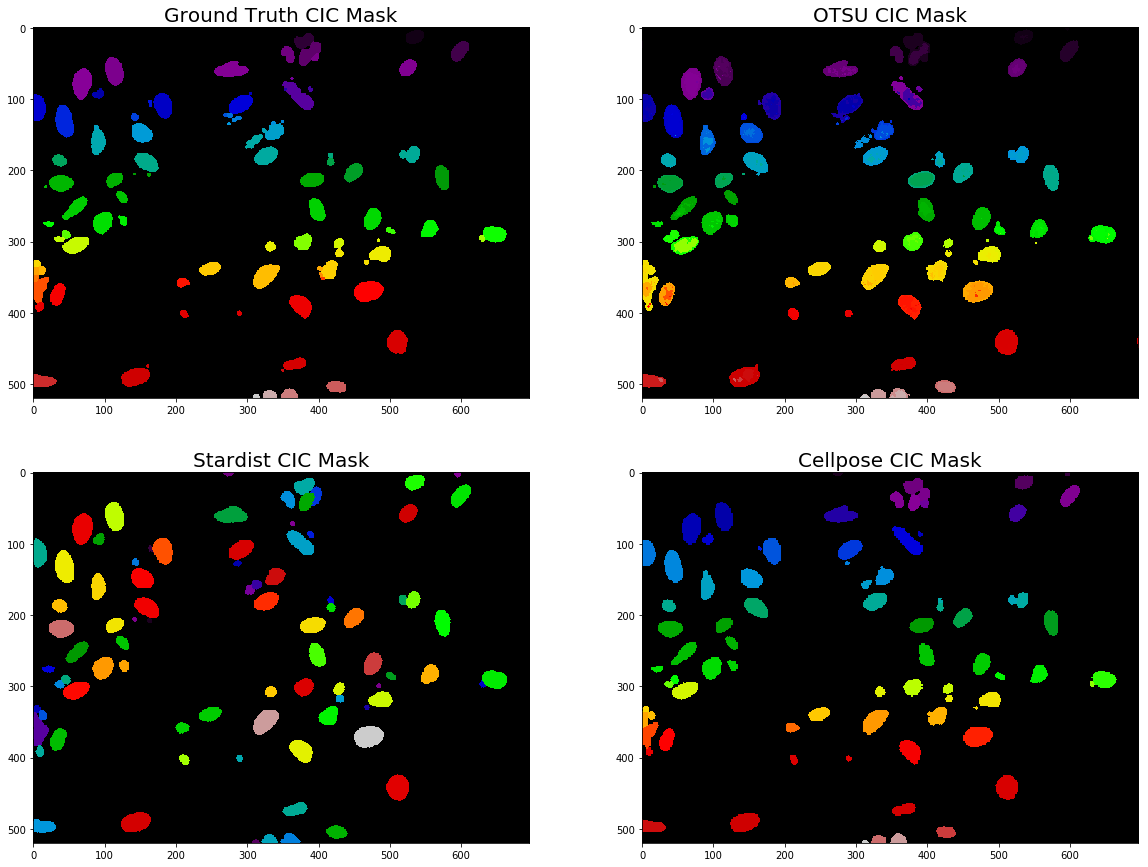

In [96]:
plt.figure(figsize = (20,15))

plt.subplot(221)   
plt.imshow(gt_cic, cmap = 'nipy_spectral')
plt.title('Ground Truth CIC Mask', fontsize = 20)

plt.subplot(222)
plt.imshow(mask_otsu, cmap = 'nipy_spectral')
plt.title('OTSU CIC Mask', fontsize = 20)

plt.subplot(223)
plt.imshow(mask_stardist, cmap = 'nipy_spectral')
plt.title('Stardist CIC Mask', fontsize = 20)

plt.subplot(224)
plt.imshow(mask_cellpose, cmap = 'nipy_spectral')
plt.title('Cellpose CIC Mask', fontsize = 20)

plt.show()

All the masks visually look quite similar. Maybe OTSU thresholding method missed some nuclei. In contrast, the masks obtained from the Stardist and Cellpose segmentation methods look very similar to the ground truth masks provided by the Broad Institute. The F1 score evaluation metric seems to support this as well. Now let us compute F1 score for each segmentation method for all the BBBC039 images demanding 90% overlap of the prediction with the ground truth CIC mask, and make boxplot comparing the F1 score  across the methods.

In [254]:
%%capture

images_path = "/home/nikolay/WABI/S_Aits/segmentation/images/images/"
masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks_rgb/masks/"

import os
my_files = os.listdir(images_path)
my_files = [i for i in my_files if i not in ['models']]
my_ids = [i.split('.tif')[0] for i in my_files]

otsu_f1 = list()
unet_f1 = list()
stardist_f1 = list()
cellpose_f1 = list()
for i in range(len(my_ids)):
    gt = skimage.io.imread(masks_path +  my_ids[i] + ".png")
    img = skimage.io.imread(images_path + my_ids[i] + ".tif")

    #IMAGE
    percentile = 99.9
    high = np.percentile(img, percentile)
    low = np.percentile(img, 100 - percentile)
    img = np.minimum(high, img)
    img = np.maximum(low, img)
    img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
    img = skimage.img_as_ubyte(img) 

    #GROUND TRUTH MASK
    gt = gt[:,:,0]
    gt_cic = skimage.morphology.label(gt)

    #OTSU MASK
    thresholds = skimage.filters.threshold_multiotsu(img, classes = 4)
    mask_otsu = skimage.morphology.label(np.digitize(img, bins = thresholds))

    #OTSU F1 SCORE
    stats_otsu = matching_dataset(mask_otsu, gt_cic, thresh = 0.9, show_progress = False)
    f1_otsu = stats_otsu._asdict()['f1']
    otsu_f1.append(f1_otsu)
    
    #STARDIST MASK
    image_norm = normalize(img, 1, 99.8)
    mask_stardist, details = model_stardist.predict_instances(image_norm)
    
    #STARDIST F1 SCORE
    stats_stardist = matching_dataset(mask_stardist, gt_cic, thresh = 0.9, show_progress = False)
    f1_stardist = stats_stardist._asdict()['f1']
    stardist_f1.append(f1_stardist)
    
    #CELLPOSE MASK
    mask_cellpose_array, _, _, _ = model.eval([img[::1, ::1]], channels = [[0, ]], diameter = 20)
    mask_cellpose = mask_cellpose_array[0]
    
    #CELLPOSE F1 SCORE
    stats_cellpose = matching_dataset(mask_cellpose, gt_cic, thresh = 0.9, show_progress = False)
    f1_cellpose = stats_cellpose._asdict()['f1']
    cellpose_f1.append(f1_cellpose)
    
    #UNET MASK
    img = open_image(images_path + my_ids[i] + ".tif", convert_mode = 'L')
    prediction = learn.predict(img)
    my_mask = prediction[0].data.numpy()[0,:,:]
    unet_cic_mask = skimage.morphology.label(np.array(prediction[0].data[0]))
    
    #UNET F1 SCORE
    stats_unet = matching_dataset(unet_cic_mask, gt_cic, thresh = 0.9, show_progress = False)
    f1_unet = stats_unet._asdict()['f1']
    unet_f1.append(f1_unet)

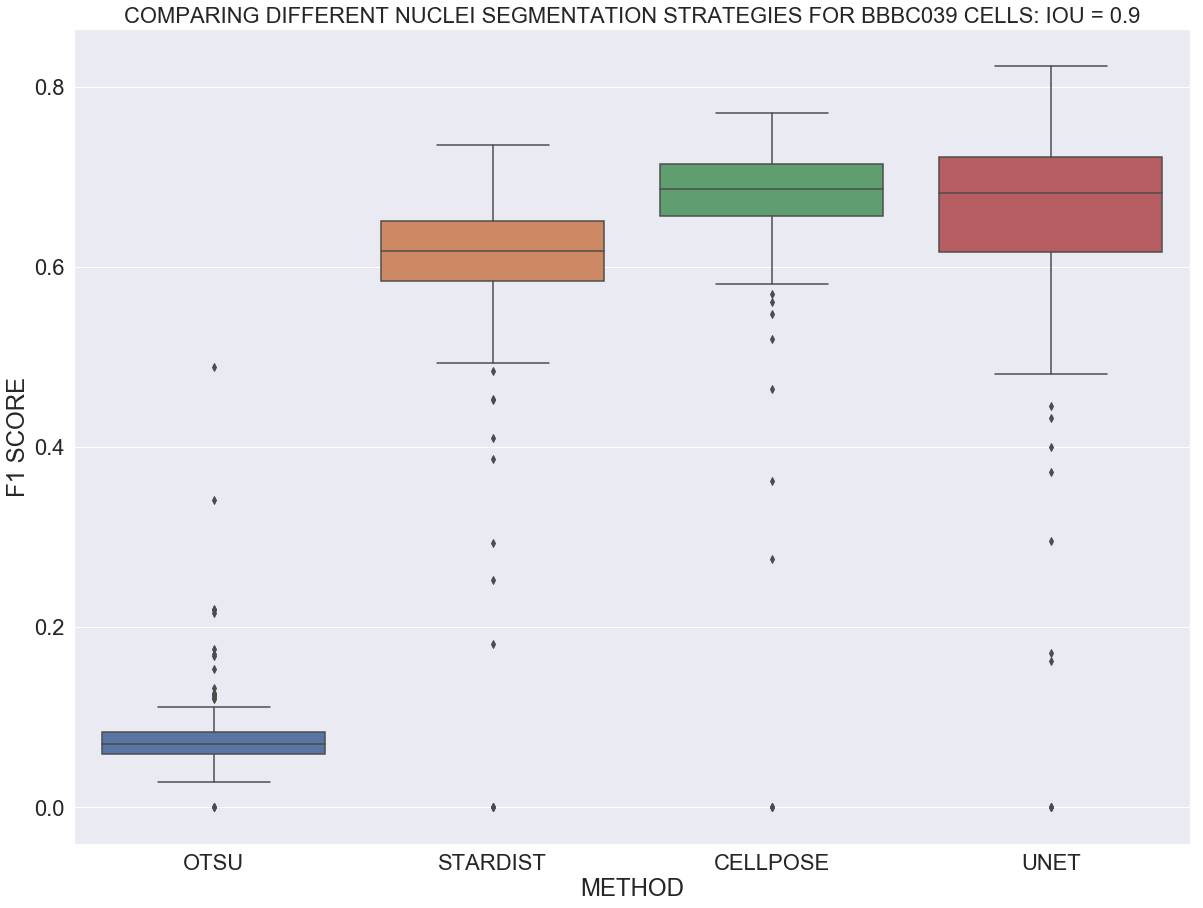

In [255]:
import pandas as pd
import seaborn as sns

my_len = len(otsu_f1)
df_f1 = pd.DataFrame({'METHOD': ['OTSU'] * my_len + ['STARDIST'] * my_len + ['CELLPOSE'] * my_len + 
                      ['UNET'] * my_len, 'F1 SCORE': otsu_f1 + stardist_f1 + cellpose_f1 + unet_f1})

sns.set(font_scale = 2)
plt.figure(figsize = (20,15))
sns.boxplot(x = 'METHOD', y = 'F1 SCORE', data = df_f1)
plt.title('COMPARING DIFFERENT NUCLEI SEGMENTATION STRATEGIES FOR BBBC039 CELLS: IOU = 0.9', fontsize = 22)
#sns.stripplot(x = 'METHOD', y = 'F1 SCORE', data = df_f1)
#plt.ylim([0.8, 1])
plt.show()

In [245]:
np.mean(unet_f1)

0.6809750860070951

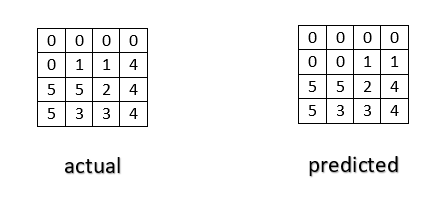

In [262]:
from IPython.display import Image
Image('/home/nikolay/WABI/S_Aits/Presentation/segmentation/mask_class.png', width = 2000)

In [260]:
%%capture

images_path = "/home/nikolay/WABI/S_Aits/segmentation/images/images/"
masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks_rgb/masks/"

import os
my_files = os.listdir(images_path)
my_files = [i for i in my_files if i not in ['models']]
my_ids = [i.split('.tif')[0] for i in my_files]

otsu_f1_class = list()
unet_f1_class = list()
for i in range(len(my_ids)):
    gt = skimage.io.imread(masks_path +  my_ids[i] + ".png")
    img = skimage.io.imread(images_path + my_ids[i] + ".tif")

    #IMAGE
    percentile = 99.9
    high = np.percentile(img, percentile)
    low = np.percentile(img, 100 - percentile)
    img = np.minimum(high, img)
    img = np.maximum(low, img)
    img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
    img = skimage.img_as_ubyte(img) 

    #GROUND TRUTH MASK
    gt = gt[:,:,0]

    #OTSU MASK
    thresholds = skimage.filters.threshold_multiotsu(img, classes = 4)
    mask_otsu = np.digitize(img, bins = thresholds)

    #OTSU F1 SCORE
    f1_otsu_class = f1_score(gt.flatten(), mask_otsu.flatten(), average = 'macro')
    otsu_f1_class.append(f1_otsu_class)
    
    #UNET MASK
    img = open_image(images_path + my_ids[i] + ".tif", convert_mode = 'L')
    prediction = learn.predict(img)
    my_mask = prediction[0].data.numpy()[0,:,:]
    unet_mask = np.array(prediction[0].data[0])
    
    #UNET F1 SCORE
    f1_unet_class = f1_score(gt.flatten(), unet_mask.flatten(), average = 'macro')
    unet_f1_class.append(f1_unet_class)

In [257]:
otsu_f1_class

[0.3789137292997953,
 0.38476314964160757,
 0.3992539868830904,
 0.43437233322944924,
 0.39232168882374474]

In [258]:
unet_f1_class

[0.48171395623907437,
 0.47764762109430375,
 0.6430762190420775,
 0.47859124287724036,
 0.6423296753353922]

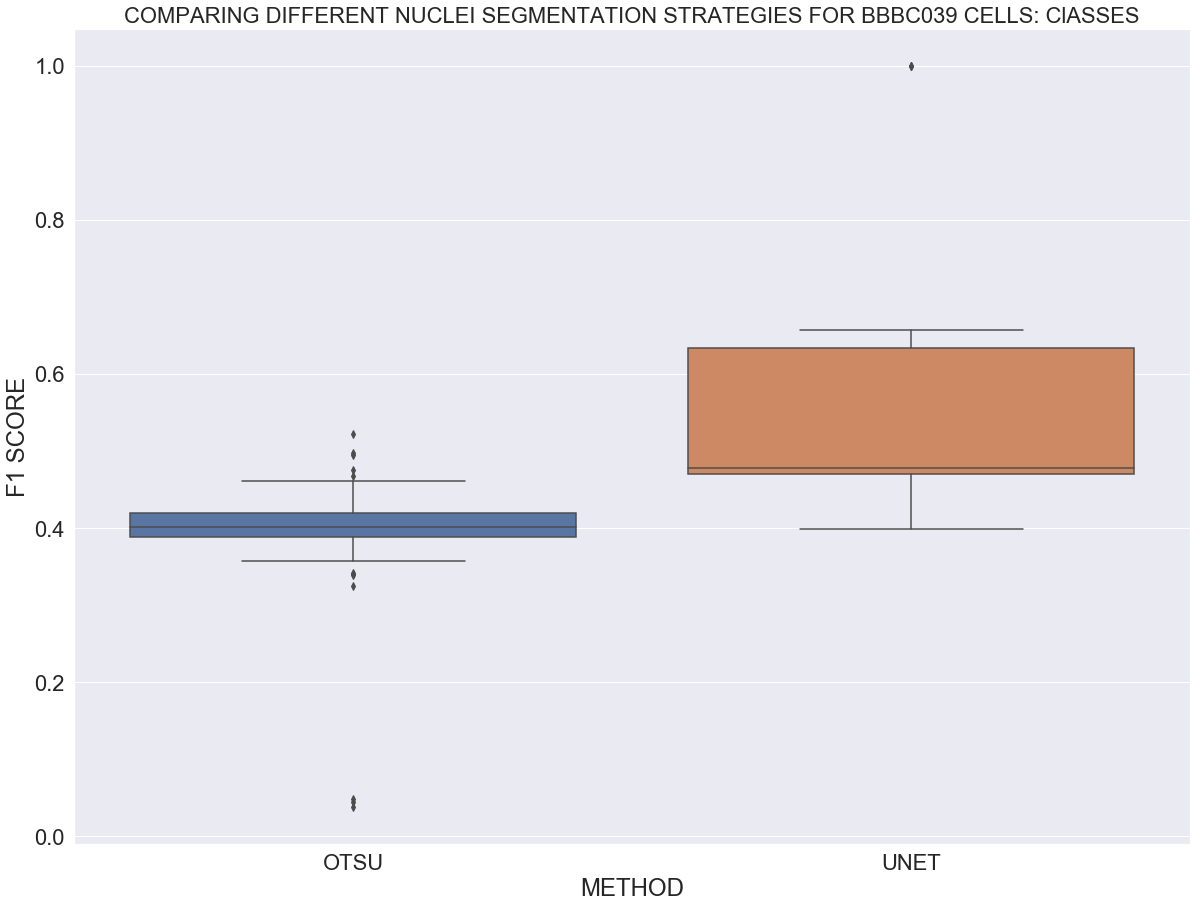

In [263]:
import pandas as pd
import seaborn as sns

my_len = len(otsu_f1_class)
df_f1_class = pd.DataFrame({'METHOD': ['OTSU'] * my_len + ['UNET'] * my_len, 
                            'F1 SCORE': otsu_f1_class + unet_f1_class})

sns.set(font_scale = 2)
plt.figure(figsize = (20,15))
sns.boxplot(x = 'METHOD', y = 'F1 SCORE', data = df_f1_class)
plt.title('COMPARING DIFFERENT NUCLEI SEGMENTATION STRATEGIES FOR BBBC039 CELLS: ClASSES', fontsize = 22)
#sns.stripplot(x = 'METHOD', y = 'F1 SCORE', data = df_f1)
#plt.ylim([0.8, 1])
plt.show()

#### Convert RGB Labels to Grayscale Labels

Until now we have used pre-trained UNET based models (Stardist and Cellpose) on the BBC039 cells. Now we will try to train our own UNET for nuclei segmentation on the BBC039 cell images. For this purpose we will use Fastai library. The catch is that Fastai accepts only Grayscale masks while we got BBC039 cell image data set contains RGB masks. So in order to use Fastai, below we will convert all the RGB masks into Grayscale masks.

In [8]:
import glob
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology

import warnings
warnings.filterwarnings('ignore')

masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks/masks/"
my_masks = glob.glob(masks_path + '*.png')

for i in range(len(my_masks)):
    gt = skimage.io.imread(my_masks[i])
    gt = gt[:,:,0]
    skimage.io.imsave(my_masks[i], gt)

#### Train UNET Neural Network for Nuclei Segmentation <a class="anchor" id="Train-UNET-Neural-Network-for-Nuclei-Segmentation"></a>

Now we will train our own UNET neural network for nuclei segmentation on the BBC039 cell microscopy images. For building UNET we will use Fastai library from Jeremy Howard. We will start with providing paths to the images and corresponding masks to be used in Fastai.

In [98]:
from fastai.vision import *

import warnings
warnings.filterwarnings('ignore')

path = '/home/nikolay/WABI/S_Aits/segmentation/'

path_lbl = path + 'masks/masks'
path_img = path + 'images/images'

fnames = get_image_files(path_img)
print(fnames[0:5])
lbl_names = get_image_files(path_lbl)
print(lbl_names[0:5])

[PosixPath('/home/nikolay/WABI/S_Aits/segmentation/images/images/IXMtest_D01_s1_w181AE787C-B5EE-4150-A90E-2FE43165C32E.tif'), PosixPath('/home/nikolay/WABI/S_Aits/segmentation/images/images/IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06.tif'), PosixPath('/home/nikolay/WABI/S_Aits/segmentation/images/images/IXMtest_I23_s5_w1E3053D6B-8CEF-48E3-A6A5-2F0D7C1AA177.tif'), PosixPath('/home/nikolay/WABI/S_Aits/segmentation/images/images/IXMtest_G06_s7_w19444140C-EF22-42DE-863A-514D836BE850.tif'), PosixPath('/home/nikolay/WABI/S_Aits/segmentation/images/images/IXMtest_O02_s4_w1814603DA-DD56-44EF-98C5-AFF3B636F986.tif')]
[PosixPath('/home/nikolay/WABI/S_Aits/segmentation/masks/masks/IXMtest_L03_s6_w1BE79472D-5E2C-422F-A16E-7AC0691C0FD8.png'), PosixPath('/home/nikolay/WABI/S_Aits/segmentation/masks/masks/IXMtest_C14_s8_w1612E3D43-FA7E-4FFB-BE53-F34A3A0CAFCD.png'), PosixPath('/home/nikolay/WABI/S_Aits/segmentation/masks/masks/IXMtest_J02_s5_w1F53DDD35-C0B2-4E39-BA3B-9F66D289AB02.png'), Posi

We will randomly select an image and open it with **open_image** function that will be used later for reading all the images from the image folder. That is why it is important to see that the random image looks ok.

/home/nikolay/WABI/S_Aits/segmentation/images/images/IXMtest_D01_s1_w181AE787C-B5EE-4150-A90E-2FE43165C32E.tif
Dimensions of the image are: torch.Size([1, 520, 696])


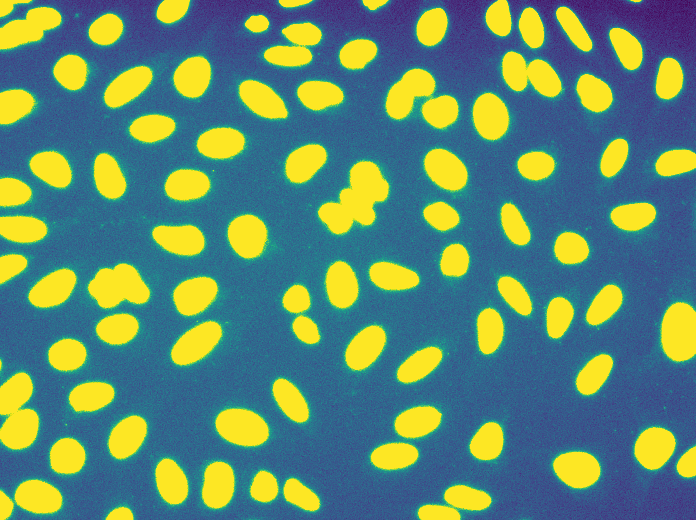

In [99]:
#images_path = '/home/nikolay/WABI/S_Aits/segmentation/images/images/'
#img = open_image(images_path + "IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.tif", convert_mode = 'L')

img_f = fnames[0]
print(img_f)
img = open_image(img_f, convert_mode = 'L')
print('Dimensions of the image are: ' + str(img.shape))
img

In [100]:
np.array(img.data).shape

(1, 520, 696)

In [101]:
np.max(np.array(img.data))

1.0

In [102]:
np.min(np.array(img.data))

0.49803922

We can see that the pixel intencities of the image were normalized to the scale \[0, 1\]. The image represents 3D array, first dimension is the number of color channels, the oter two dimensions are the image size (pixels). Now we are going to define a function that for each image finds the corresponding mask / label, the label has an extension **.png** but the same ID as the corresponding image.

In [103]:
get_y_fn = lambda x: path_lbl + '/' + str(x.stem) + '.png'
print(get_y_fn(img_f))

/home/nikolay/WABI/S_Aits/segmentation/masks/masks/IXMtest_D01_s1_w181AE787C-B5EE-4150-A90E-2FE43165C32E.png


Now we are going to display the mask / label fpr the previously randomly selected image. The mask is already on the Grayscale since we have previously converted all the masks from RGB to Grayscale.

Dimensions of the mask are: torch.Size([1, 520, 696])


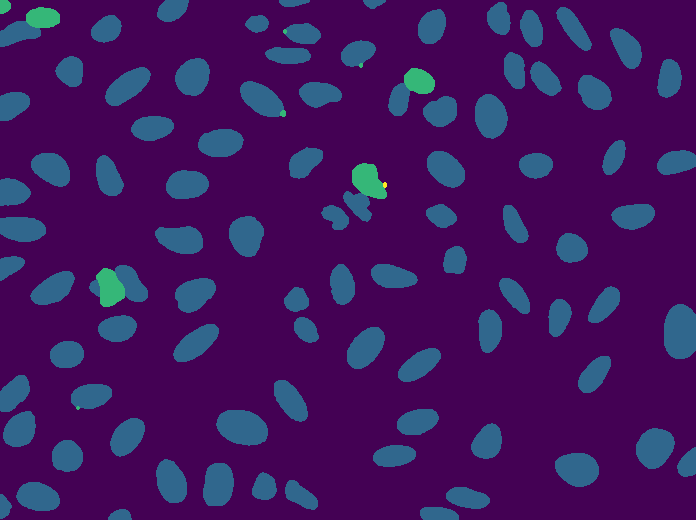

In [104]:
#masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks/masks/"
#mask = open_mask(masks_path + "IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png")

mask = open_mask(get_y_fn(img_f))
print('Dimensions of the mask are: ' + str(mask.shape))
mask

In [105]:
np.array(mask.data).shape

(1, 520, 696)

In [106]:
np.min(np.array(mask.data))

0

In [107]:
np.max(np.array(mask.data))

3

We can see that the mask represent a 3D array, and the elements of the array vary from 0 to 3 since there are 4 classes present on each image: Background, Nuclei, Boundary and Noise. To really demonstrate that all the masks contain values from 0 to 3, below we will plot a histogram of the mask array elements.

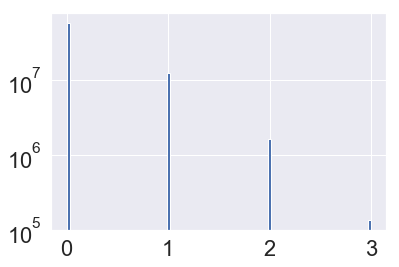

In [156]:
import glob
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology

masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks_rgb/masks/"
my_masks = glob.glob(masks_path + '*.png')

my_labels = []
for i in range(len(my_masks)):
    gt = skimage.io.imread(my_masks[i])
    gt = gt[:,:,0]
    my_labels.append(list(gt.flatten()))

my_labels = [item for sublist in my_labels for item in sublist]
plt.hist(my_labels, bins = 100, log = True)
plt.show()

We can see that there are three classes present on the images. Background, Nuclei, Boundary and Noise. Now everythong is ready for constructing the main object SegmentationItemList. We will apply some transforms / normalization to the images and display a typical batch of them.

In [108]:
codes = np.loadtxt(path + 'codes.txt', dtype = str) # Load data codes
print(codes)

src_size = np.array(mask.shape[1:])
#size = src_size//2
size = src_size
bs = 4

#class SegLabelListCustom(SegmentationLabelList):
#        def open(self, fn): return open_mask(fn, convert_mode = 'RGB')

#class SegItemListCustom(SegmentationItemList):
#    _label_cls = SegLabelListCustom

src = (SegmentationItemList.from_folder(path_img)
       # Load in x data from folder
       .split_by_fname_file(path + 'valid.txt')
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes = codes)
       # Label data using the get_y_fn function
)

data = (src.transform(get_transforms(), size = size, tfm_y = True)
        # Flip images horizontally 
        .databunch(bs = bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

['Background' 'Nuclei' 'Boundary' 'Noise']


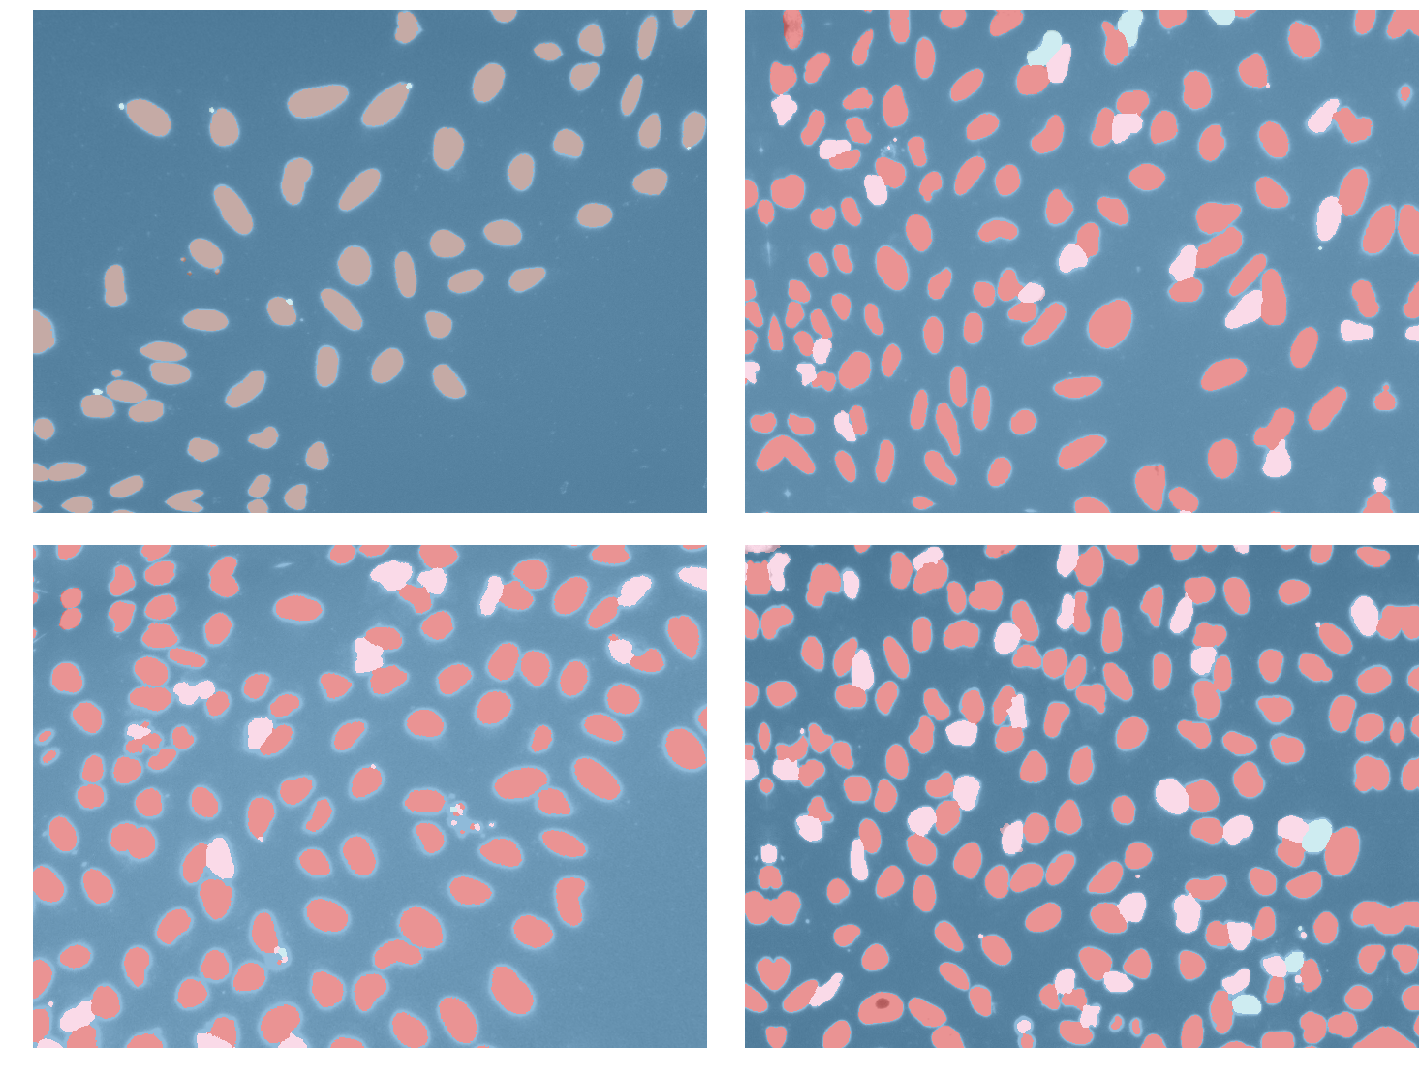

In [109]:
data.show_batch(rows = 2, figsize = (20, 15))

Below we will define an accuracy function that computes overlap of each pixel label with the ground truth label from the mask for all pixels except the Background pixels. We need to exlude Background as including it will make the accuracy artificially high as the majority of the image pixels belong to the Background class.

In [111]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_nuclei(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim = 1)[mask] == target[mask]).float().mean()

Now we will perform learning rate hyperparameter tuning. fastai provides a handy tool for this purpose.

In [123]:
learn = unet_learner(data, models.resnet34, metrics = acc_nuclei, wd = 1e-2)

In [16]:
learn.lr_find(start_lr = 1e-7, end_lr = 0.03, stop_div = False, num_it = 100) # find learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


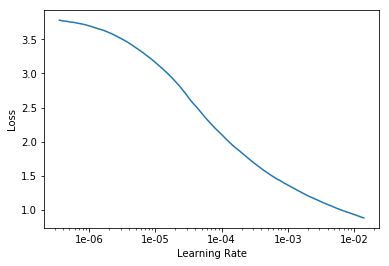

In [17]:
learn.recorder.plot() # plot learning rate graph

Min numerical gradient: 2.92E-05
Min loss divided by 10: 1.41E-03


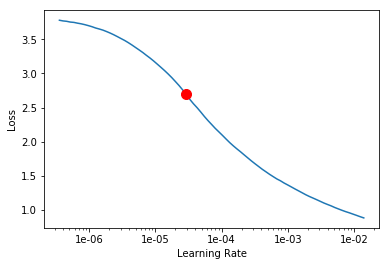

In [18]:
fig = learn.recorder.plot(suggestion = True, return_fig = True)

Now, we will pick the optimal learning rate obtained by the hyperparameter tuning, and will start training of our UNET neural netrwork.

In [19]:
lr = 5e-3 # pick a lr
learn.fit_one_cycle(5, slice(lr), pct_start = 0.9) # train model

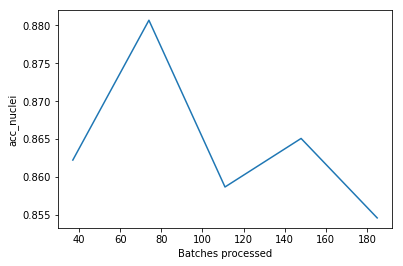

In [20]:
learn.recorder.plot_metrics()

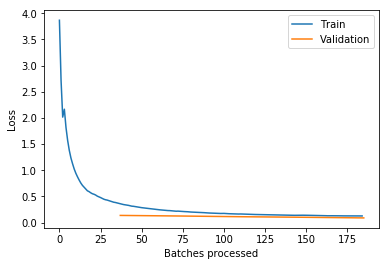

In [21]:
learn.recorder.plot_losses()

In [22]:
learn.save('nuclei-stage-3') # save model

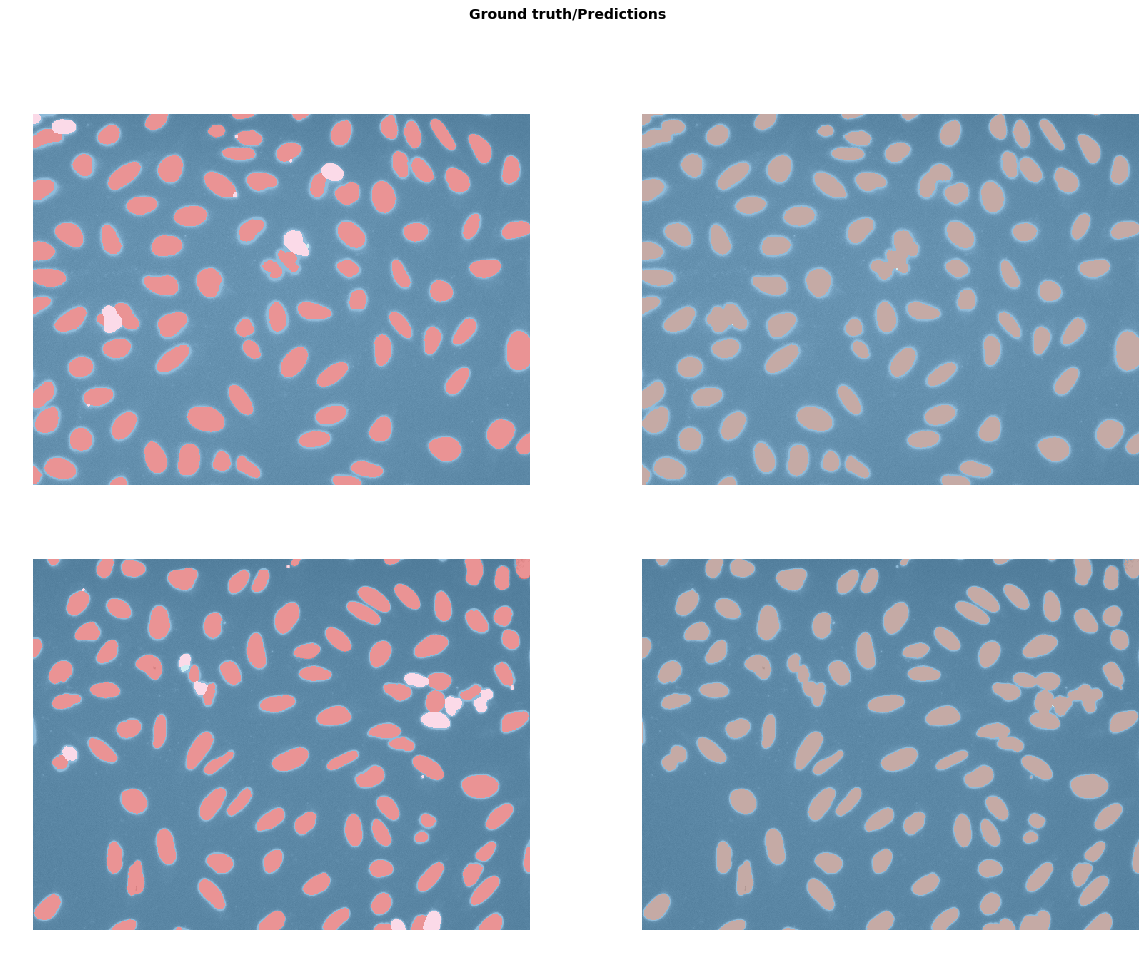

In [23]:
learn.show_results(rows = 2, figsize = (20, 15)) # show results

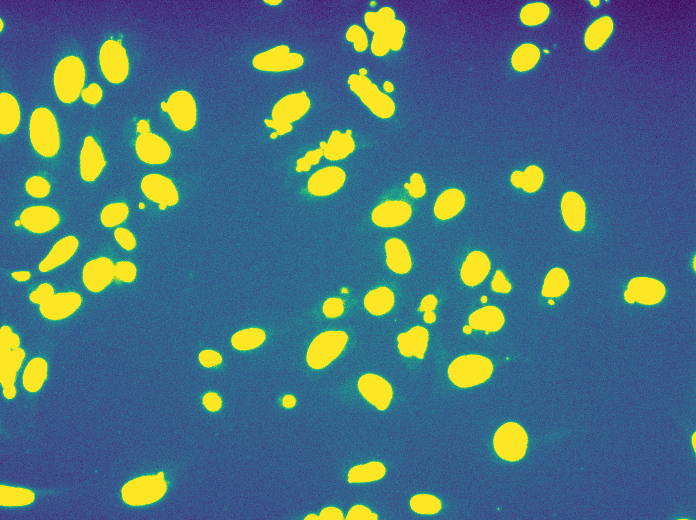

In [112]:
from fastai.vision import *

learn = unet_learner(data, models.resnet34, metrics = acc_nuclei, wd = 1e-2)
learn.load('nuclei-stage-3')
images_path = '/home/nikolay/WABI/S_Aits/segmentation/images/images/'
#test_img = open_image(images_path + "IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.tif", 
#                      convert_mode = 'L')
test_img = open_image(images_path + "IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06.tif", 
                      convert_mode = 'L')
test_img

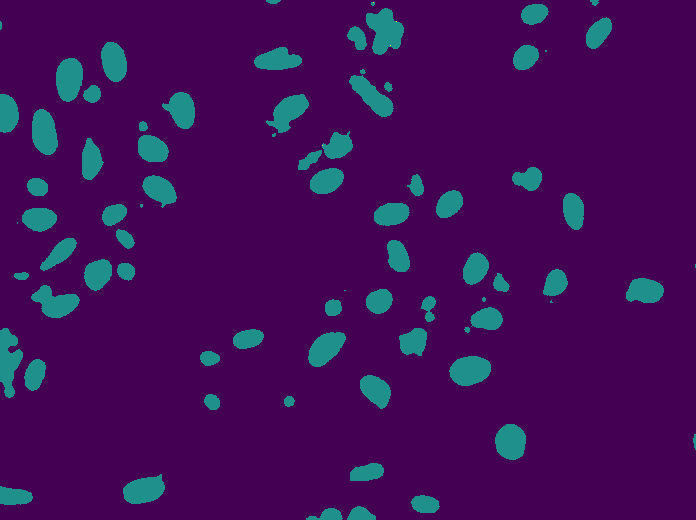

In [113]:
prediction = learn.predict(test_img)
#prediction[0].show(figsize=(20,15))
prediction[0]

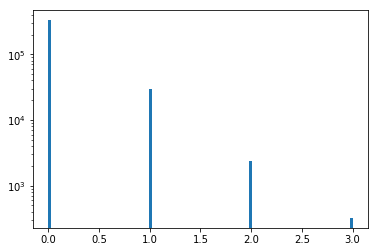

In [114]:
#gt = skimage.io.imread(masks_path + "IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png")
gt = skimage.io.imread(masks_path + "IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06.png")
gt = gt[:,:,0]
gt_cic = skimage.morphology.label(gt)
plt.hist(gt.flatten(), bins = 100, log = True)
plt.show()

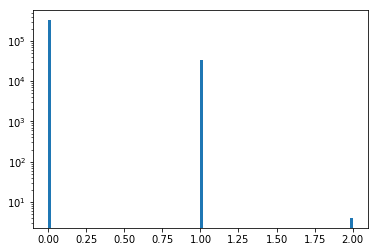

In [115]:
my_mask = prediction[0].data.numpy()[0,:,:]
plt.hist(my_mask.flatten(), bins = 100, log = True)
plt.show()

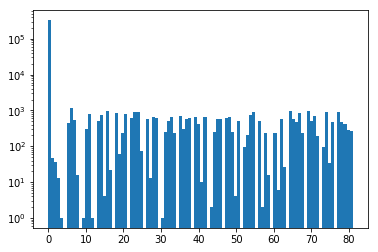

In [116]:
unet_cic_mask = skimage.morphology.label(np.array(prediction[0].data[0]))
plt.hist(unet_cic_mask.flatten(), bins = 100, log = True)
plt.show()

In [117]:
from stardist.matching import matching_dataset
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
stats_unet = [matching_dataset(unet_cic_mask, gt_cic, thresh = t, show_progress = False) for t in taus]

In [118]:
f1_unet = [stats_unet[i]._asdict()['f1'] for i in range(len(taus))]
f1_unet

[0.9169695275370422,
 0.9141738887335756,
 0.9052278445624825,
 0.8957226726306962,
 0.8783897120492032,
 0.8426055353648308,
 0.7850153760134191,
 0.7229521945764608,
 0.5954710651383841,
 0.18339390550740844]

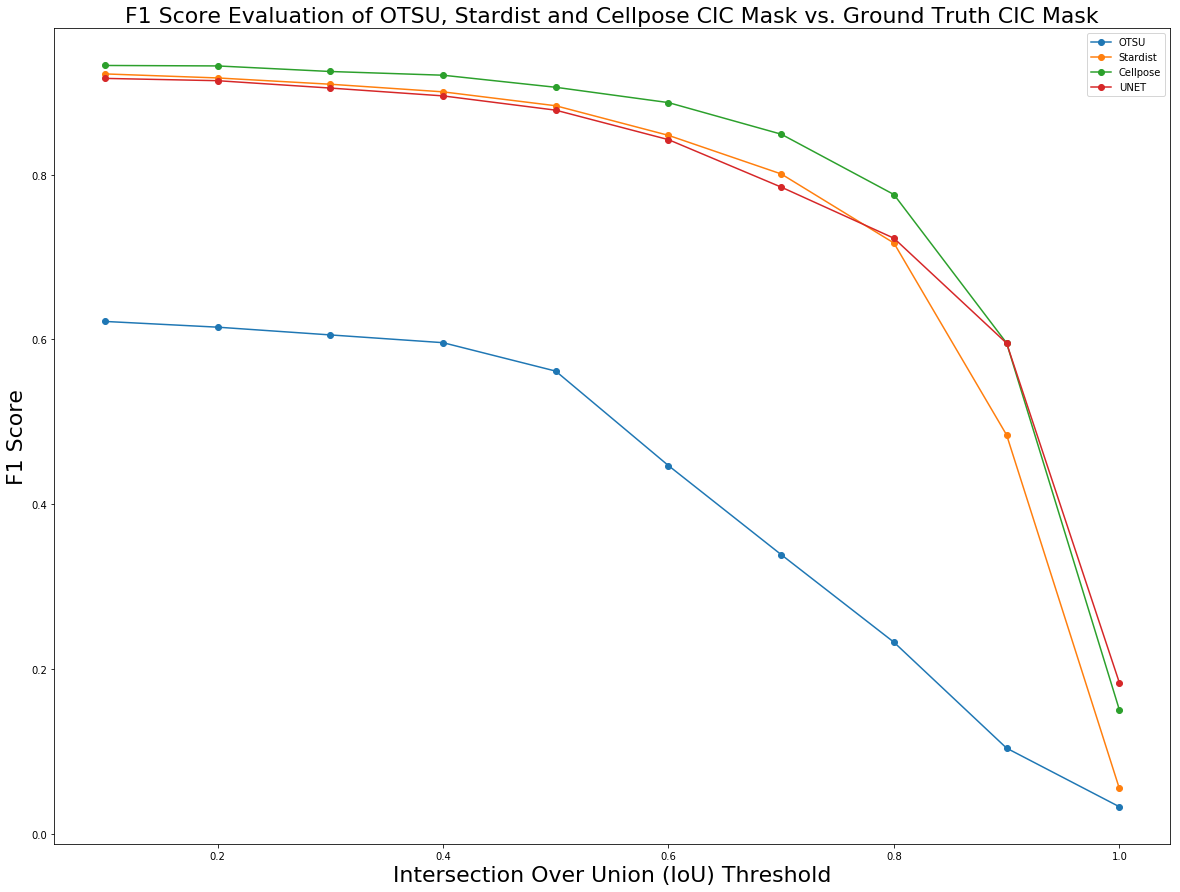

In [119]:
plt.figure(figsize = (20,15))
plt.plot(taus, f1_otsu, '-o')
plt.plot(taus, f1_stardist, '-o')
plt.plot(taus, f1_cellpose, '-o')
plt.plot(taus, f1_unet, '-o')
plt.title('F1 Score Evaluation of OTSU, Stardist and Cellpose CIC Mask vs. Ground Truth CIC Mask', fontsize = 22)
plt.xlabel('Intersection Over Union (IoU) Threshold', fontsize = 22)
plt.ylabel('F1 Score', fontsize = 22)
plt.legend(['OTSU', 'Stardist', 'Cellpose', 'UNET'])
plt.show()

In [225]:
from sklearn.metrics import accuracy_score
accuracy_score(gt.flatten(), my_mask.flatten())

0.970388483642794

In [226]:
from sklearn.metrics import f1_score
f1_score(gt.flatten(), my_mask.flatten(), average = 'macro')

0.47873602661389114

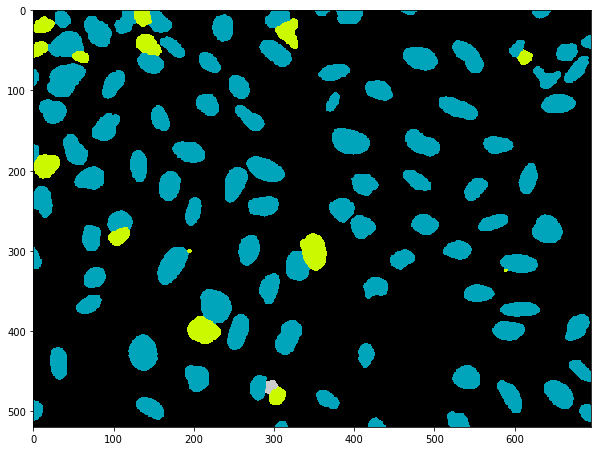

In [26]:
import skimage.io
import skimage.morphology
import matplotlib.pyplot as plt

masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks_rgb/masks/"
gt = skimage.io.imread(masks_path + "IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png")
# Keep first channel only
gt = gt[:,:,0]
#gt = skimage.morphology.label(gt)

plt.figure(figsize = (10,8))
plt.imshow(gt, cmap = 'nipy_spectral')
plt.show()

In [27]:
#from skimage.transform import rescale, resize
#gt_resized = resize(gt, (gt.shape[0] // 2, gt.shape[1] // 2), anti_aliasing=True)

my_mask = prediction[0].data.numpy()[0,:,:]

intersection = np.logical_and(gt, my_mask)
union = np.logical_or(gt, my_mask)
unet_iou_score = np.sum(intersection) / np.sum(union)
print(unet_iou_score)

0.9450546406459923


In [28]:
my_mask

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]])

In [29]:
my_mask.shape

(520, 696)

In [30]:
gt

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8)

In [31]:
gt.shape

(520, 696)

In [32]:
np.max(gt)

3

In [33]:
np.max(my_mask)

2

#### Train Mask-RCNN Neural Network for Nuclei Segmentation <a class="anchor" id="Train-Mask-RCNN-Neural-Network-for-Nuclei-Segmentation"></a>

Now we will train our own Mask-RCNN neural network for nuclei segmentation on the BBC039 cell microscopy images. We will start with providing paths to the images and corresponding masks to be used in Mask-RCNN.

In [1]:
import sys
sys.path.insert(1, '/home/nikolay/WABI/S_Aits/segmentation/Mask_RCNN/')

import os
import keras
import skimage
from numpy import zeros
from numpy import asarray
import skimage.morphology
from mrcnn.utils import Dataset
 
# class that defines and loads the Nucleus dataset
class NucleusDataset(Dataset):

    def load_nucleus(self, dataset_dir, is_train = True):
        # define classes present on microscopy images
        self.add_class("nucleus", 1, "nucleus")
        #self.add_class("nucleus", 2, "Touching Nuclei")
        #self.add_class("nucleus", 3, "In-Between Touching Nuclei")
        
        # define data locations
        annotations_dir = dataset_dir + 'masks_rgb/masks/'
        images_dir = dataset_dir + 'images/images/'
        
        for i, filename in zip(range(len(os.listdir(images_dir))), os.listdir(images_dir)):
            # extract image id
            image_id = filename[:-4]
            # skip all images after 190 if we are building the train set
            if is_train and i >= 5:
                continue
            # skip all images before 190 if we are building the test / val set
            if not is_train and i < 5:
                continue
        
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.png'
            self.add_image('nucleus', image_id = image_id, path = img_path, annotation = ann_path)
 
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        mask = keras.utils.to_categorical(skimage.morphology.label(skimage.io.imread(path)[:,:,0]))
        #mask = keras.utils.to_categorical(skimage.io.imread(path)[:,:,0]).astype(np.bool)
        #mask = keras.utils.to_categorical(skimage.io.imread(path)[:,:,0])
        mask = mask[:,:,1:mask.shape[-1]]
        return mask, np.ones([mask.shape[-1]], dtype = np.int32)
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "nucleus":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

# train set
train_set = NucleusDataset()
train_set.load_nucleus('/home/nikolay/WABI/S_Aits/segmentation/', is_train = True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test / val set
test_set = NucleusDataset()
test_set.load_nucleus('/home/nikolay/WABI/S_Aits/segmentation/', is_train = False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Using TensorFlow backend.


Train: 5
Test: 196


In [2]:
print('Train data set:')
print("Image Count: {}".format(len(train_set.image_ids)))
print("Class Count: {}".format(train_set.num_classes))
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))
print('************************************************************')
    
print('Test data set:')
print("Image Count: {}".format(len(test_set.image_ids)))
print("Class Count: {}".format(test_set.num_classes))
for i, info in enumerate(test_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Train data set:
Image Count: 5
Class Count: 2
  0. BG                                                
  1. nucleus                                           
************************************************************
Test data set:
Image Count: 196
Class Count: 2
  0. BG                                                
  1. nucleus                                           


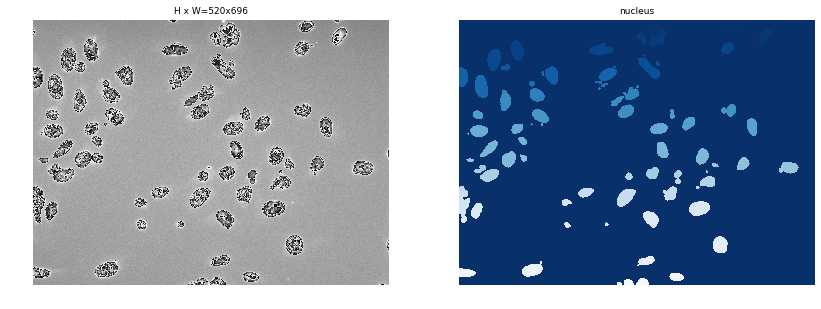

In [4]:
# Load and display random samples
import skimage
import numpy as np
from mrcnn import visualize
#image_ids = np.random.choice(train_set.image_ids, 2)
image_ids = np.array([1])
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names, limit = 1)

In [5]:
mask.shape

(520, 696, 101)

In [6]:
class_ids

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [7]:
class_ids.shape

(101,)

In [8]:
from mrcnn.model import log
from mrcnn import model as modellib
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances

from mrcnn.config import Config
from mrcnn.model import MaskRCNN

import warnings
warnings.filterwarnings("ignore")

class NucleusConfig(Config):
    
    NAME = "nucleus"
    
    # Number of classes (background + Nuclei)
    NUM_CLASSES = 1 + 1
    
    # Number of training steps per epoch: number of images in the training data set
    STEPS_PER_EPOCH = 10
    
    #IMAGE_RESIZE_MODE = "none"
    #IMAGE_RESIZE_MODE = "square"
    #IMAGE_RESIZE_MODE = "crop"
    #IMAGE_RESIZE_MODE = "pad64"
    #IMAGE_MIN_DIM = 256
    #IMAGE_MAX_DIM = 256
    
    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture. Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing: random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400

# prepare config
config = NucleusConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

molded_image             shape: (512, 512, 3)         min:  125.00000  max: 2543.00000  uint16
mask                     shape: (512, 512, 27)        min:    0.00000  max:    1.00000  float32


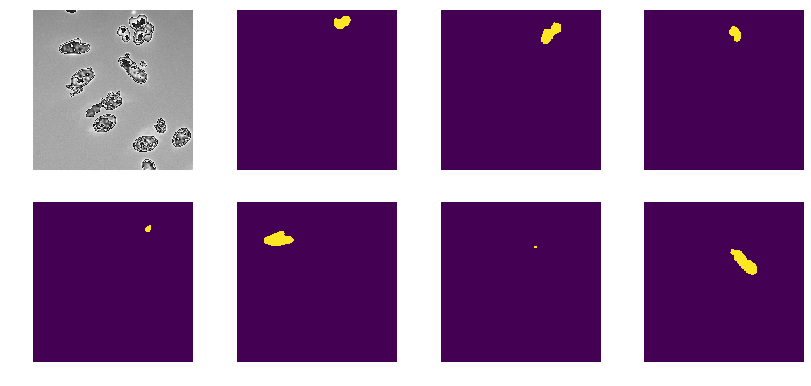

In [9]:
# Load and display
image_id = 1
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        train_set, config, image_id, use_mini_mask = False)
log("molded_image", image)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

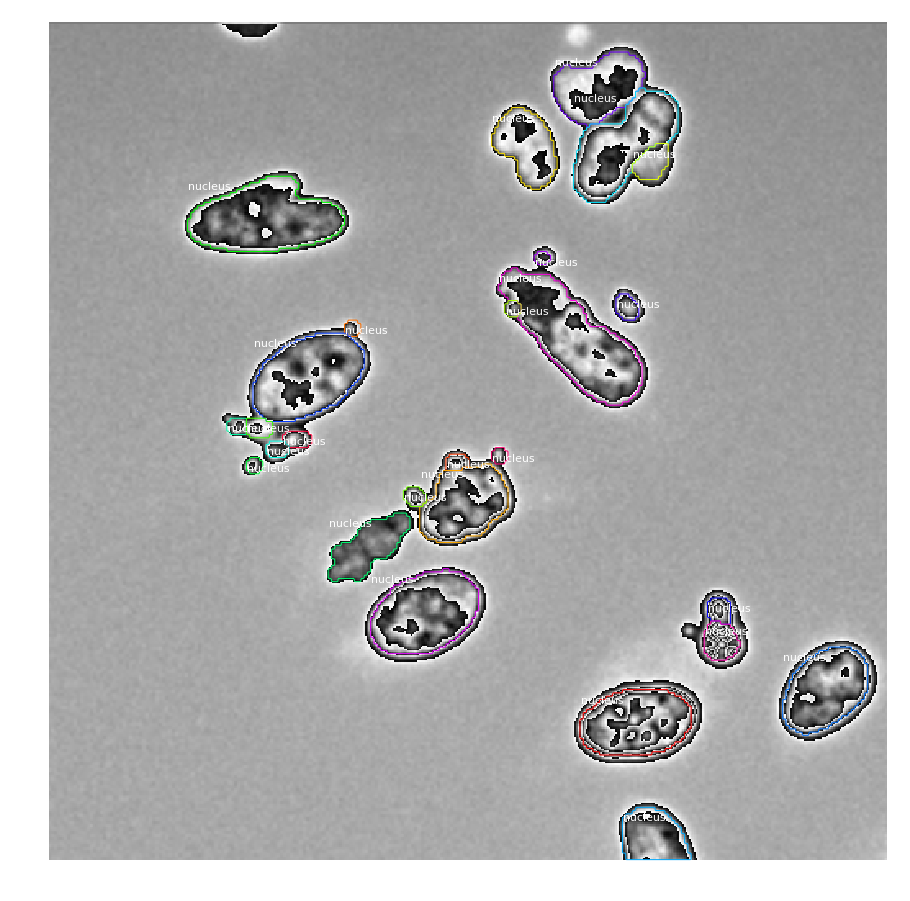

In [10]:
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names,
                            show_bbox = False, show_mask = False)

In [11]:
from mrcnn.model import MaskRCNN

import warnings
warnings.filterwarnings("ignore")

# define the model
model = MaskRCNN(mode = 'training', model_dir = '/home/nikolay/WABI/S_Aits/segmentation/', config = config)

# load weights (mscoco)
model.load_weights('/home/nikolay/WABI/Misc/HPA/mask_rcnn_coco.h5', by_name = True, 
                   exclude = ["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# train weights (output layers or 'heads')
model.train(train_set, train_set, learning_rate = config.LEARNING_RATE, epochs = 5, layers = 'heads')

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/nikolay/WABI/S_Aits/segmentation/nucleus20201111T1803/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn

In [12]:
print("Images: {}\nClasses: {}".format(len(train_set.image_ids), train_set.class_names))

Images: 5
Classes: ['BG', 'nucleus']


In [13]:
class NucleusInferenceConfig(NucleusConfig):
    NAME = "nucleus_inference"
    # Number of classes (background + Nuclei)
    #NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_RESIZE_MODE = "none"
    #IMAGE_RESIZE_MODE = "square"
    #IMAGE_RESIZE_MODE = "crop"
    IMAGE_RESIZE_MODE = "pad64"
    #IMAGE_MIN_DIM = 256
    #IMAGE_MAX_DIM = 256
    RPN_NMS_THRESHOLD = 0.7

# Inference Configuration
cfg = NucleusInferenceConfig()
cfg.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [14]:
#cfg = nucleus.NucleusInferenceConfig()
model_inf = MaskRCNN(mode = 'inference', model_dir = '/home/nikolay/WABI/S_Aits/segmentation/', config = cfg)
model_inf.load_weights('/home/nikolay/WABI/S_Aits/segmentation/nucleus20201111T1803/mask_rcnn_nucleus_0060.h5', 
                       by_name = True)

Re-starting from epoch 60


In [15]:
image_id = 1
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(train_set, cfg, image_id, 
                                                                          use_mini_mask = False)

In [16]:
gt_mask.shape

(1088, 1408, 101)

In [17]:
info = train_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       train_set.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

image ID: nucleus.IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06 (1) IXMtest_L01_s3_w1E7E0D198-5FB4-4E10-A27C-C46463DA9E06
Original image shape:  [520 696   3]


In [18]:
# Run object detection
results = model_inf.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose = 1)

Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max: 4095.00000  uint16
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max: 4095.00000  uint16
image_metas              shape: (1, 14)               min:    1.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32


In [19]:
from mrcnn.model import log

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

gt_class_id              shape: (101,)                min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (101, 4)              min:    8.00000  max: 1336.00000  int32
gt_mask                  shape: (1088, 1408, 101)     min:    0.00000  max:    1.00000  float32


In [20]:
r['rois'].shape

(84, 4)

In [21]:
r['masks'].shape

(1088, 1408, 84)

In [22]:
from mrcnn import utils

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'], verbose = 1)

AP @0.50:	 0.801
AP @0.55:	 0.788
AP @0.60:	 0.788
AP @0.65:	 0.746
AP @0.70:	 0.694
AP @0.75:	 0.622
AP @0.80:	 0.575
AP @0.85:	 0.489
AP @0.90:	 0.299
AP @0.95:	 0.010
AP @0.50-0.95:	 0.581


0.5811181670504908

In [23]:
import matplotlib.pyplot as plt
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize = (size*cols, size*rows))
    fig.tight_layout()
    return ax

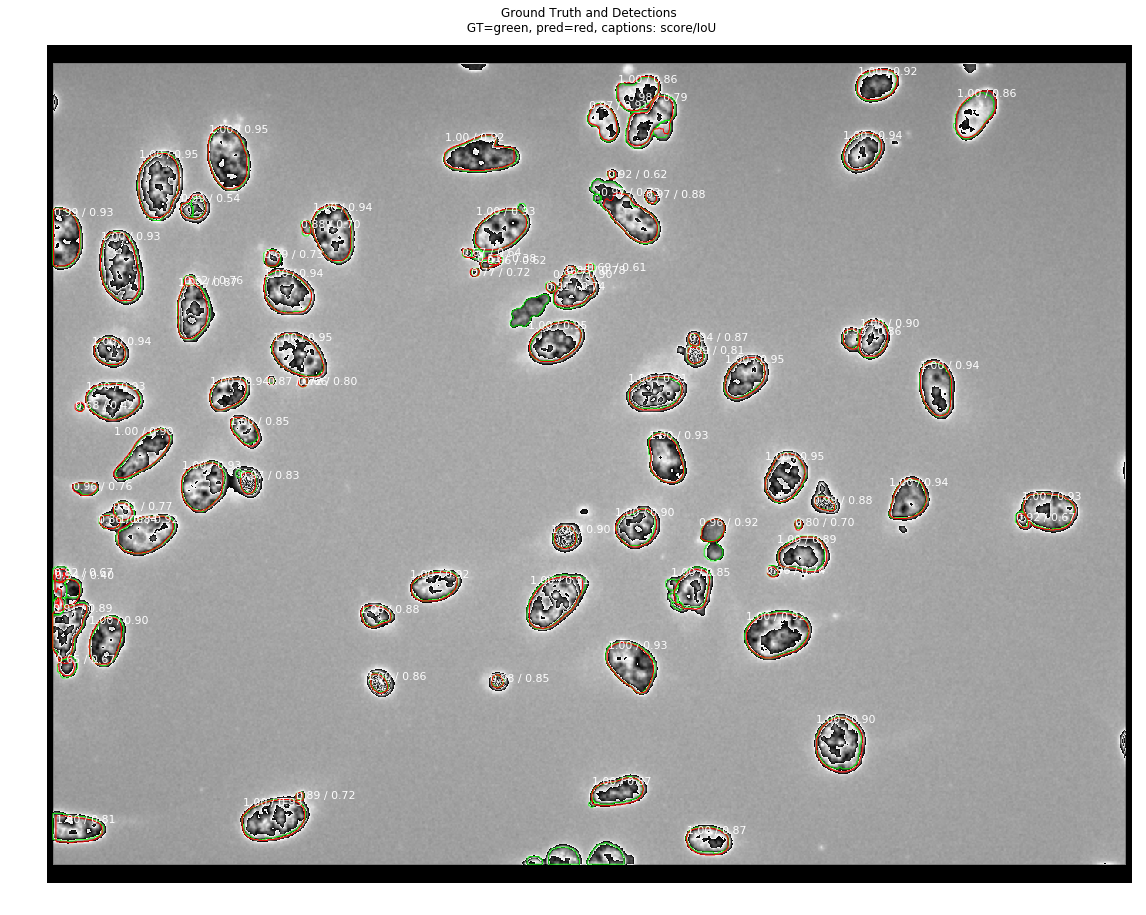

In [24]:
visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    train_set.class_names, ax = get_ax(),
    show_box = False, show_mask = False,
    iou_threshold = 0.5, score_threshold = 0.5)

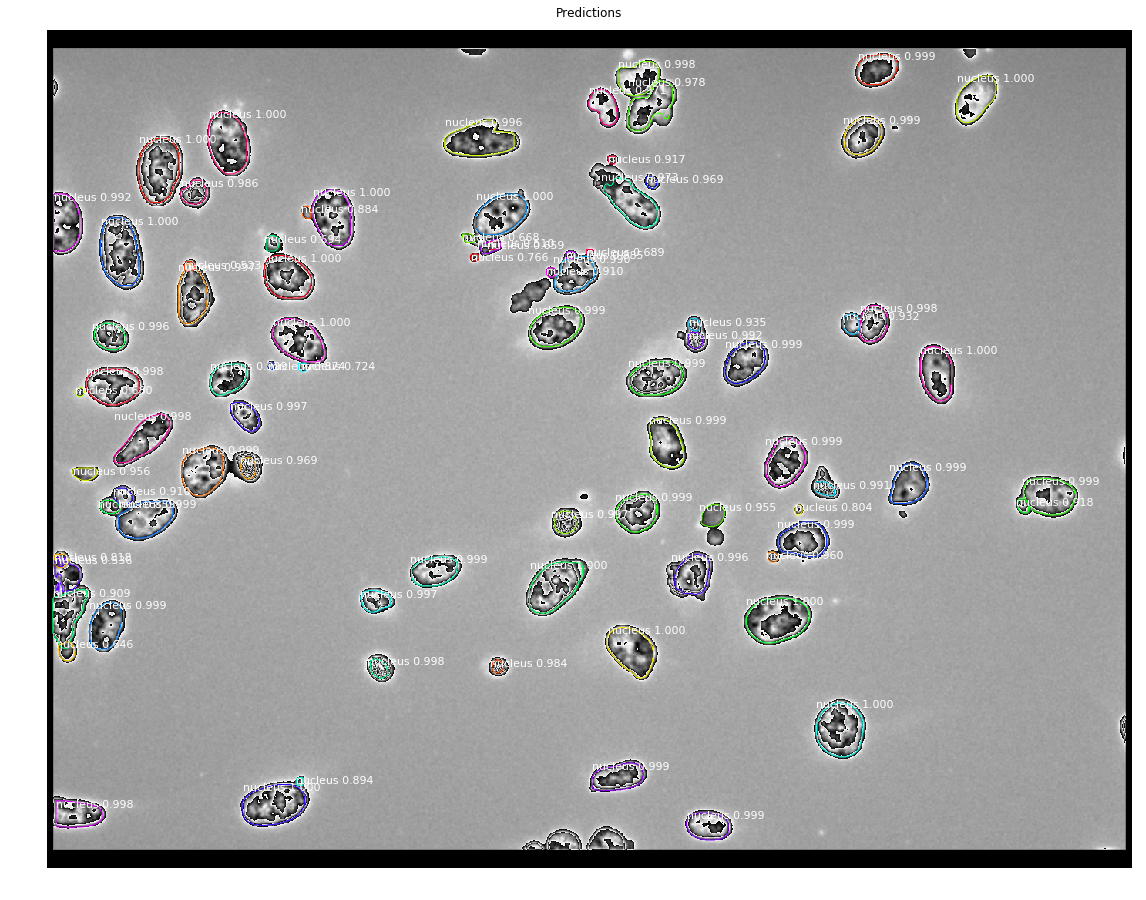

In [25]:
# Display predictions only
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                             train_set.class_names, r['scores'], ax = get_ax(1),
                             show_bbox = False, show_mask = False,
                             title = "Predictions")

In [26]:
r['masks'].shape

(1088, 1408, 84)

In [27]:
binary_mask = np.sum(r['masks'], axis = 2)
binary_mask.shape

(1088, 1408)

In [28]:
np.max(binary_mask)

2

In [29]:
rgb_mask = skimage.morphology.label(binary_mask)
rgb_mask.shape

(1088, 1408)

In [30]:
np.max(rgb_mask)

85

In [31]:
gt_mask.shape

(1088, 1408, 101)

In [32]:
np.max(gt_mask)

1.0

In [33]:
gt_binary_mask = np.sum(gt_mask, axis = 2)
gt_binary_mask.shape

(1088, 1408)

In [34]:
gt_cic = skimage.morphology.label(gt_binary_mask)
gt_cic.shape

(1088, 1408)

In [35]:
np.max(gt_cic)

75

In [36]:
from stardist.matching import matching_dataset
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
stats_maskrcnn = [matching_dataset(rgb_mask, gt_cic, thresh = t, show_progress = False) for t in taus]

In [37]:
f1_maskrcnn = [stats_maskrcnn[i]._asdict()['f1'] for i in range(len(taus))]
f1_maskrcnn

[0.9320359281437126,
 0.9281437125748503,
 0.9242514970059881,
 0.918562874251497,
 0.9059880239520958,
 0.8841317365269461,
 0.8437125748502994,
 0.7865269461077844,
 0.6392215568862275,
 0.05269461077844311]

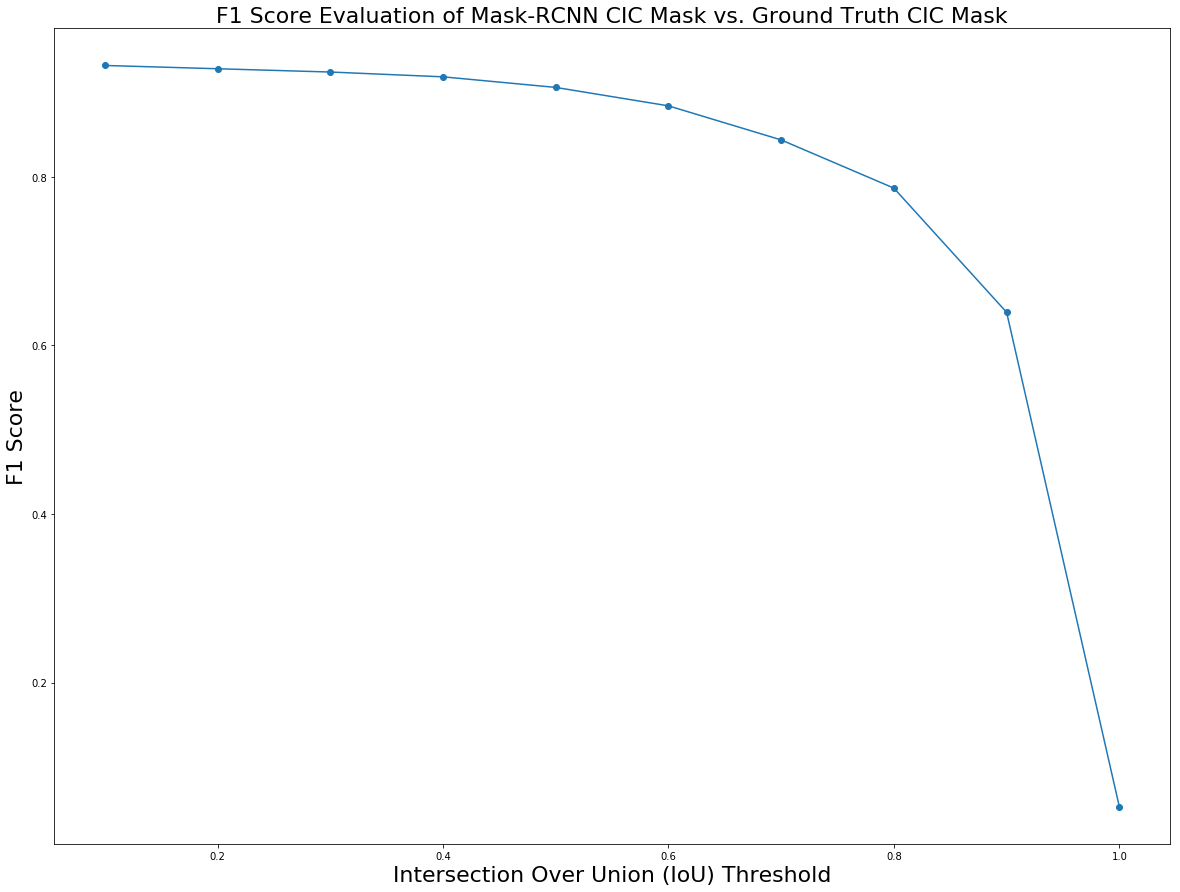

In [38]:
plt.figure(figsize = (20,15))
plt.plot(taus, f1_maskrcnn, '-o')
plt.title('F1 Score Evaluation of Mask-RCNN CIC Mask vs. Ground Truth CIC Mask', fontsize = 22)
plt.xlabel('Intersection Over Union (IoU) Threshold', fontsize = 22)
plt.ylabel('F1 Score', fontsize = 22)
plt.show()

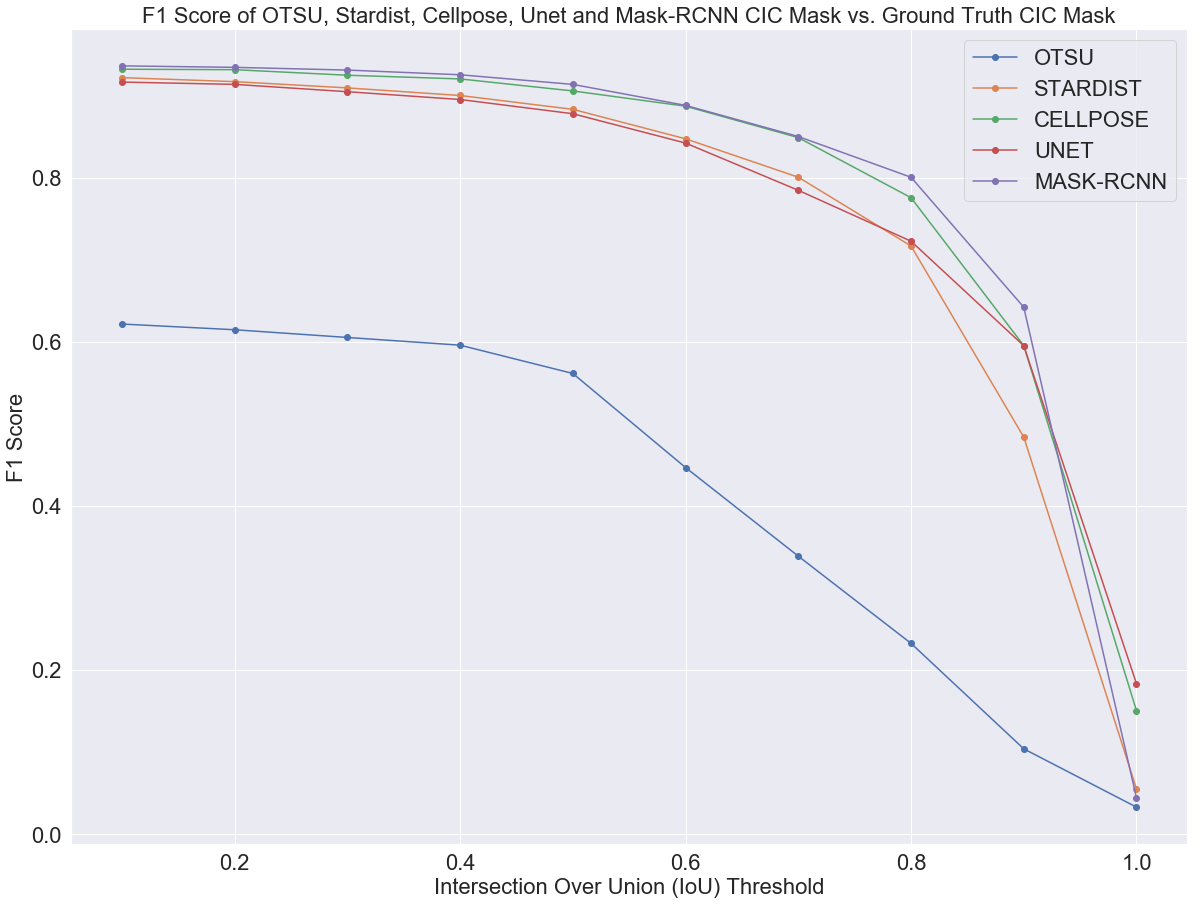

In [121]:
import seaborn as sns
sns.set(font_scale = 2)

plt.figure(figsize = (20,15))
plt.plot(taus, f1_otsu, '-o')
plt.plot(taus, f1_stardist, '-o')
plt.plot(taus, f1_cellpose, '-o')
plt.plot(taus, f1_unet, '-o')
plt.plot(taus, f1_maskrcnn, '-o')
plt.title('F1 Score of OTSU, Stardist, Cellpose, Unet and Mask-RCNN CIC Mask vs. Ground Truth CIC Mask', 
          fontsize = 22)
plt.xlabel('Intersection Over Union (IoU) Threshold', fontsize = 22)
plt.ylabel('F1 Score', fontsize = 22)
plt.legend(['OTSU', 'STARDIST', 'CELLPOSE', 'UNET', 'MASK-RCNN'], fontsize = 22)
plt.show()

In [148]:
images_path = "/home/nikolay/WABI/S_Aits/segmentation/images/images/"
masks_path = "/home/nikolay/WABI/S_Aits/segmentation/masks_rgb/masks/"

import os
from csbdeep.utils import normalize
my_files = os.listdir(images_path)
my_files = [i for i in my_files if i not in ['models']]
#my_ids = [i.split('.tif')[0] for i in my_files]
my_ids = [i['id'] for i in train_set.image_info]

otsu_f1 = list()
unet_f1 = list()
stardist_f1 = list()
cellpose_f1 = list()
maskrcnn_f1 = list()
for i in range(len(my_ids)):
    gt = skimage.io.imread(masks_path +  my_ids[i] + ".png")
    img = skimage.io.imread(images_path + my_ids[i] + ".tif")

    #IMAGE
    percentile = 99.9
    high = np.percentile(img, percentile)
    low = np.percentile(img, 100 - percentile)
    img = np.minimum(high, img)
    img = np.maximum(low, img)
    img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
    img = skimage.img_as_ubyte(img) 

    #GROUND TRUTH MASK
    gt = gt[:,:,0]
    gt_cic = skimage.morphology.label(gt)

    #OTSU MASK
    thresholds = skimage.filters.threshold_multiotsu(img, classes = 4)
    mask_otsu = skimage.morphology.label(np.digitize(img, bins = thresholds))

    #OTSU F1 SCORE
    stats_otsu = matching_dataset(mask_otsu, gt_cic, thresh = 0.9, show_progress = False)
    f1_otsu = stats_otsu._asdict()['f1']
    otsu_f1.append(f1_otsu)
    
    #STARDIST MASK
    image_norm = normalize(img, 1, 99.8)
    mask_stardist, details = model_stardist.predict_instances(image_norm)
    
    #STARDIST F1 SCORE
    stats_stardist = matching_dataset(mask_stardist, gt_cic, thresh = 0.9, show_progress = False)
    f1_stardist = stats_stardist._asdict()['f1']
    stardist_f1.append(f1_stardist)
    
    #CELLPOSE MASK
    mask_cellpose_array, _, _, _ = model.eval([img[::1, ::1]], channels = [[0, ]], diameter = 20)
    mask_cellpose = mask_cellpose_array[0]
    
    #CELLPOSE F1 SCORE
    stats_cellpose = matching_dataset(mask_cellpose, gt_cic, thresh = 0.9, show_progress = False)
    f1_cellpose = stats_cellpose._asdict()['f1']
    cellpose_f1.append(f1_cellpose)
    
    #UNET MASK
    img = open_image(images_path + my_ids[i] + ".tif", convert_mode = 'L')
    prediction = learn.predict(img)
    my_mask = prediction[0].data.numpy()[0,:,:]
    unet_cic_mask = skimage.morphology.label(np.array(prediction[0].data[0]))
    
    #UNET F1 SCORE
    stats_unet = matching_dataset(unet_cic_mask, gt_cic, thresh = 0.9, show_progress = False)
    f1_unet = stats_unet._asdict()['f1']
    unet_f1.append(f1_unet)
    
    #MASK-RCNN MASK
    image,image_meta,gt_class_id,gt_bbox,gt_mask = modellib.load_image_gt(train_set, cfg, i, use_mini_mask = False)
    r = model_inf.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose = 1)[0]
    binary_mask = np.sum(r['masks'], axis = 2)
    rgb_mask = skimage.morphology.label(binary_mask)
    gt_binary_mask = np.sum(gt_mask, axis = 2)
    gt_cic = skimage.morphology.label(gt_binary_mask)
    
    #MASK-RCNN F1 SCORE
    stats_maskrcnn = matching_dataset(rgb_mask, gt_cic, thresh = 0.9, show_progress = False)
    f1_maskrcnn = stats_maskrcnn._asdict()['f1']
    maskrcnn_f1.append(f1_maskrcnn)
    
    print('Finished ' + str(i + 1) + ' images')
    print('***************************************************************************')

processing 1 image(s)
time spent: running network 13.46s; flow+mask computation 0.65
estimated masks for 1 image(s) in 14.12 sec
>>>> TOTAL TIME 14.12 sec
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max: 1937.00000  uint16
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max: 1937.00000  uint16
image_metas              shape: (1, 14)               min:    0.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
Finished 0 images
***************************************************************************
processing 1 image(s)
time spent: running network 16.47s; flow+mask computation 0.46
estimated masks for 1 image(s) in 16.94 sec
>>>> TOTAL TIME 16.94 sec
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max: 4095.00000  uint16
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max: 409

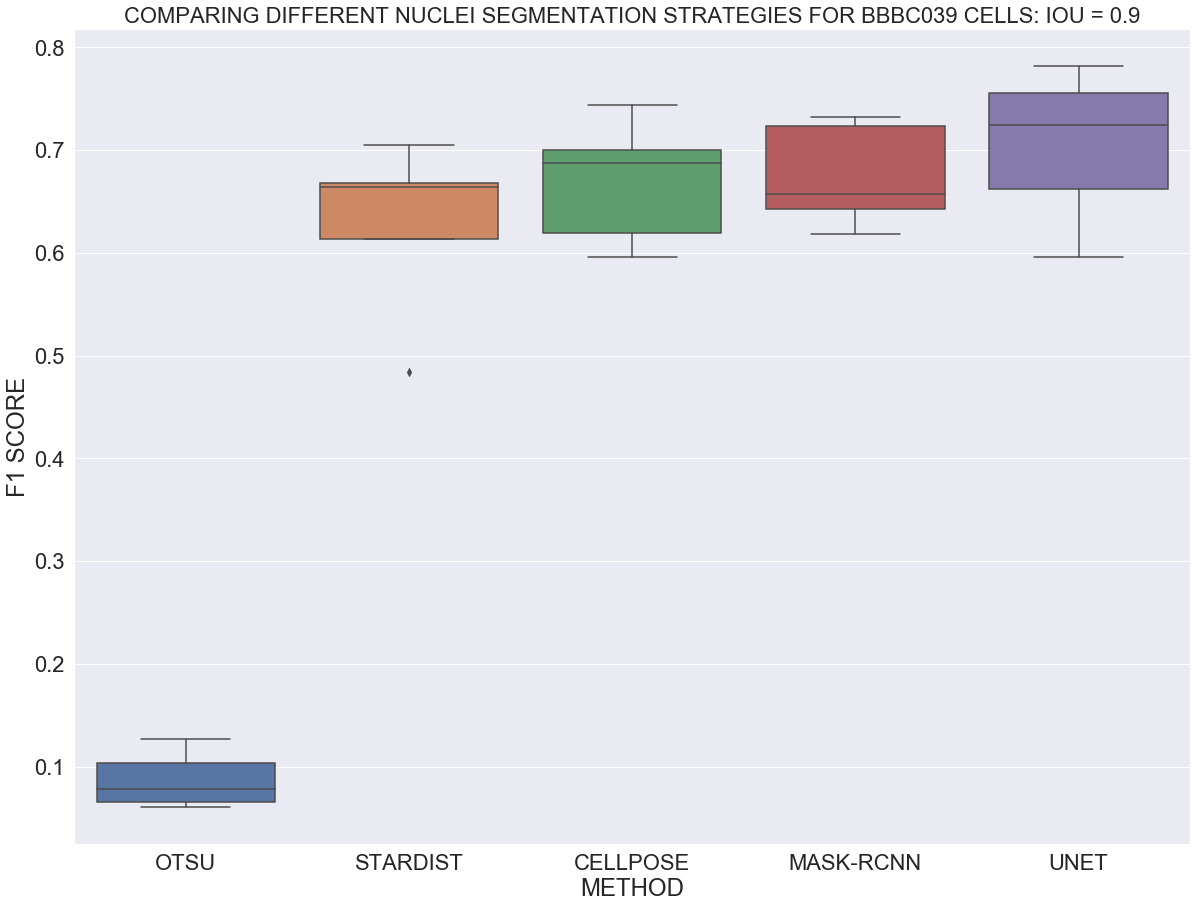

In [150]:
import pandas as pd
import seaborn as sns

my_len = len(otsu_f1)
df_f1 = pd.DataFrame({'METHOD': ['OTSU'] * my_len + ['STARDIST'] * my_len + ['CELLPOSE'] * my_len + 
                      ['MASK-RCNN'] * my_len + ['UNET'] * my_len, 
                      'F1 SCORE': otsu_f1 + stardist_f1 + cellpose_f1 + maskrcnn_f1 + unet_f1})

sns.set(font_scale = 2)
plt.figure(figsize = (20,15))
sns.boxplot(x = 'METHOD', y = 'F1 SCORE', data = df_f1)
plt.title('COMPARING DIFFERENT NUCLEI SEGMENTATION STRATEGIES FOR BBBC039 CELLS: IOU = 0.9', fontsize = 22)
#sns.stripplot(x = 'METHOD', y = 'F1 SCORE', data = df_f1)
#plt.ylim([0.8, 1])
plt.show()

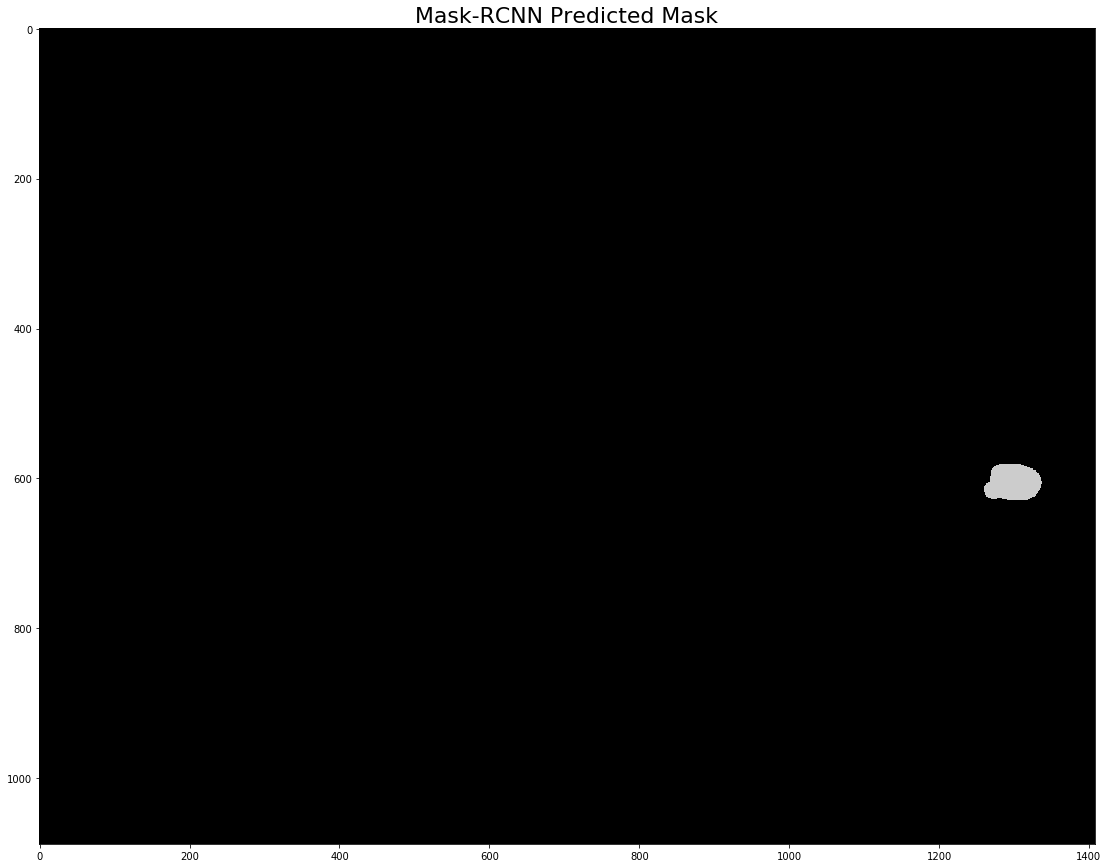

In [30]:
plt.figure(figsize = (20,15))
plt.imshow(r['masks'][:,:,10], cmap = 'nipy_spectral')
plt.title('Mask-RCNN Predicted Mask', fontsize = 22)
plt.show()

In [11]:
from mrcnn.model import MaskRCNN

import warnings
warnings.filterwarnings("ignore")

# define the model
model = MaskRCNN(mode = 'training', model_dir = '/home/nikolay/WABI/S_Aits/segmentation/', config = config)

# load weights (mscoco)
#model.load_weights('/home/nikolay/WABI/Misc/HPA/mask_rcnn_coco.h5', by_name = True, 
#                   exclude = ["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

model.load_weights('/home/nikolay/WABI/S_Aits/segmentation/nucleus20201111T1803/mask_rcnn_nucleus_0030.h5', 
                   by_name = True)

# train weights (output layers or 'heads')
model.train(train_set, train_set, learning_rate = config.LEARNING_RATE, epochs = 60, layers = 'all')

Re-starting from epoch 30
Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 30. LR=0.001

Checkpoint Path: /home/nikolay/WABI/S_Aits/segmentation/nucleus20201111T1803/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchN

10/10 [==============================] - 1119s 112s/step - loss: 0.6603 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.2760 - mrcnn_class_loss: 0.1152 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1391 - val_loss: 0.7320 - val_rpn_class_loss: 0.0397 - val_rpn_bbox_loss: 0.3456 - val_mrcnn_class_loss: 0.1225 - val_mrcnn_bbox_loss: 0.0859 - val_mrcnn_mask_loss: 0.1383
Epoch 40/60
10/10 [==============================] - 1118s 112s/step - loss: 0.6816 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1372 - val_loss: 0.7075 - val_rpn_class_loss: 0.0295 - val_rpn_bbox_loss: 0.3290 - val_mrcnn_class_loss: 0.1263 - val_mrcnn_bbox_loss: 0.0897 - val_mrcnn_mask_loss: 0.1330
Epoch 41/60
10/10 [==============================] - 1114s 111s/step - loss: 0.6680 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1229 - val_loss: 0.7271 - val_rpn_class_loss: 0

In [25]:
config.DETECTION_MIN_CONFIDENCE

0.7